In [624]:
#Imports and Settings
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from operator import mul
import seaborn as sn
import random

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Helper Functions
from helper import predict, confusion_matrix1, calculate_threshold_values, plot_roc
#Pandas Settings to Display Rows and Cols
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

#Matplotlib Style Settings
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

#Pandas Standaridzer for Float Formatting
#pd.options.display.float_format = '{:,.2f}'.format
#pd.reset_option('display.float_format')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

In [2]:
# Looping through data folder to concat CSV's into one big dataframe
# 1002400 rows in dataset
# 63 columns
# Reinitialize HERE

for i,name in tqdm(enumerate(glob.glob('data/CSV/*'))):
    if i == 0:
        df = pd.read_csv(name)
    df2 = pd.read_csv(name)
    concat = pd.concat([df,df2],ignore_index=True)
    df = concat

In [3]:
#Back Up Reinitilization 
data = df.copy()

In [489]:
# Reinitilize DF
%time df = data.copy()

CPU times: user 272 ms, sys: 448 ms, total: 720 ms
Wall time: 719 ms


In [490]:
df.head(1)

,M,LA_No,T_No,Classics_Request_ID,End_Of_Run,Start_Date,First_Date,Last_Date,Play_Dates,FRM,Release,Local,Media_Formats,Rental_Measure,Theatre,Status,Boxoffice,Boxoffice_Net,Film_Rental,To_Receive,Admissions,FRM_Perc,Terms_Perc,Price,Min_Max,MG_FF,Office,Customer_Reference,Film_Buyer,Buying_Circuit,Payer,Remark,Payer_Remark,DType,Aspect_Ratio,Sound_System,Seat_Type,Amenity,Frame_Rate,Resolution,Projection_Type,Licensor,L,Hire,Rem_,Rem_Date,Show,Media_Type,Dim_,LV,Division,Branch,TV_Market,Area,Circuit,City,Seeks_Run,No,Usage,VPF_Company,Sales,Screen,NENR
0,-,00081065-01,1,NaN,n,3/16/2018 00:00:00,3/16/2018 00:00:00,3/18/2018 00:00:00,03/16;03/17;03/18,ff,"LEGO NINJAGO MOVIE, THE",2066081.0,ENG.2.DIG.0.0.0.0,none,MARCUS ST. CLAIR 10,Approved,0.0,0.0,175.0,175.0,0,0.0,-,0,-,175.0,ENCINO OFFICE,NaN,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,NaN,NaN,no,no,no,none,none,none,none,none,None,NaN,0.0,0.0,1/1/1950 00:00:00,Normal,no,-,non,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO",MARCUS THEATRES,"FAIRVIEW HEIGHTS, IL",OTHER - Temp Close,( 1 ),1.0,Cinedigm 2,sgoyette,MARCUS ST. CLAIR 10,NaN


In [491]:
#Trimming off extraneous columns
df = df.iloc[:,1:57]
df = df.drop(['Classics_Request_ID','End_Of_Run','Play_Dates','Start_Date','Local','Rental_Measure','Boxoffice_Net',
              'Film_Rental','To_Receive','FRM_Perc','Min_Max','MG_FF','Price','Customer_Reference','Office',
             'Remark','Payer_Remark','DType','Aspect_Ratio','Sound_System','Seat_Type','Amenity','Frame_Rate',
             'Resolution','Projection_Type','Licensor','L','Hire','Rem_','Rem_Date','Media_Type','Dim_','LV','Circuit'],axis=1)
#Data Leakage
#df = df.drop('Admissions',axis=1)
df.head(2)

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
0,00081065-01,1,3/16/2018 00:00:00,3/18/2018 00:00:00,ff,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,MARCUS ST. CLAIR 10,Approved,0.0,0,-,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,Normal,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO","FAIRVIEW HEIGHTS, IL",OTHER - Temp Close
1,00085822-14,14,2/24/2018 00:00:00,2/24/2018 00:00:00,sp,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,KINGSWAY 2,Returns In,0.0,0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE - Temp Close


In [492]:
#Drop any duplicate ID's
df.drop_duplicates('LA_No',inplace=True)

#Dropping any non SP payments
df = df[df['FRM']=='sp'] 

# Only looking at records with grosses returned
df = df[df['Status']=='Returns In']

df = df[df.Division != 'CLASSICS']

#Dropping 500 NAN media formats
df = df.dropna(axis=0)

#Not in YT Data
df = df[df.Release !='THEY SHALL NOT GROW OLD']
df = df[df.Release !='FANTASTIC BEASTS AND WHERE TO FIND THEM']

In [493]:
df['First_Date'] = pd.to_datetime(df['First_Date'])
df['Last_Date'] = pd.to_datetime(df['Last_Date'])

df['Boxoffice'] = df['Boxoffice'].astype(str)
df['Boxoffice'] = df['Boxoffice'].apply(lambda x: x.replace(',', ''))
df['Boxoffice'] = df['Boxoffice'].astype(float)
df['T_No'] = df['T_No'].astype(float)

# Removed Admissions because of data leakage
df['Admissions'] = df['Admissions'].astype(str)
df['Admissions'] = df['Admissions'].apply(lambda x: x.replace(',', ''))
df['Admissions'] = df['Admissions'].astype(float)


In [494]:
def format_assign(x):
    if 'IMAX' in x or 'IXD'in x or 'DIMX' in x:     
        return 'IMAX'
    if 'PLF' in x or 'PLD' in x:
        return 'PLF'
    elif '3D' in x:
        return '3D'
    else:
        return '2D'

def seeks_run(x):
    if 'FIRST' in x:
        return 'FIRST RUN'
    elif 'LATE' in x:
        return 'LATE RUN'
    elif 'SUB' in x:
        return 'SUB RUN'
    else:
        return 'OTHER'
    # Intermediate Run, Other-Temp Close, IMAX, Art House, Calendar, Classics

df['Media_Formats'] = df['Media_Formats'].astype(str)
df['Media_Formats'] = df['Media_Formats'].swifter.apply(format_assign)
df['Seeks_Run'] = df['Seeks_Run'].swifter.apply(seeks_run)

In [495]:
df

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
1,00085822-14,14.0,2018-02-24,2018-02-24,sp,"LEGO NINJAGO MOVIE, THE",2D,KINGSWAY 2,Returns In,0.00,0.0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE RUN
2,00087068-12,12.0,2018-02-16,2018-02-22,sp,"LEGO NINJAGO MOVIE, THE",2D,CANYON MEADOWS 10,Returns In,1149.54,230.0,35,"HUNTER, NATHALIE",1335422 ALBERTA LTD,1335422 ALBERTA LTD,Normal,CANADIAN,CALGARY,CALGARY,"CALGARY, AB","CALGARY, AB",LATE RUN
3,00085822-13,13.0,2018-02-16,2018-02-17,sp,"LEGO NINJAGO MOVIE, THE",2D,KINGSWAY 2,Returns In,0.00,0.0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE RUN
4,00087068-11,11.0,2018-02-09,2018-02-15,sp,"LEGO NINJAGO MOVIE, THE",2D,CANYON MEADOWS 10,Returns In,1074.57,215.0,35,"HUNTER, NATHALIE",1335422 ALBERTA LTD,1335422 ALBERTA LTD,Normal,CANADIAN,CALGARY,CALGARY,"CALGARY, AB","CALGARY, AB",LATE RUN
5,00085822-12,12.0,2018-02-09,2018-02-15,sp,"LEGO NINJAGO MOVIE, THE",2D,KINGSWAY 2,Returns In,52.00,4.0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE RUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011263,00028470-01,1.0,2017-04-07,2017-04-13,sp,GOING IN STYLE (2017),2D,YAKIMA 10,Returns In,10258.53,1218.0,52.0,"LENCIONI, BRIGIT",ALAMO THEATRE SERVICES,YAKIMA THEATRES INC.,Normal,WESTERN,SEATTLE,YAKIMA,"YAKIMA, WA","YAKIMA, WA",FIRST RUN
1011264,00011664-01,1.0,2017-04-06,2017-04-12,sp,GOING IN STYLE (2017),2D,MOUNDS VIEW 15,Returns In,3903.67,585.0,44.5,"CANDELAS, SERGIO",AMERICAN MULTI-CINEMA,AMERICAN MULTI-CINEMA,Normal,EASTERN,MINNEAPOLIS,MINNEAPOLIS,"MINNEAPOLIS, MN","MOUNDS VIEW, MN",FIRST RUN
1011265,00011822-01,1.0,2017-04-06,2017-04-12,sp,GOING IN STYLE (2017),2D,OAKDALE 20,Returns In,1764.06,260.0,44.5,"CANDELAS, SERGIO",AMERICAN MULTI-CINEMA,AMERICAN MULTI-CINEMA,Normal,EASTERN,MINNEAPOLIS,MINNEAPOLIS,"MINNEAPOLIS, MN","OAKDALE, MN",FIRST RUN
1011266,00011361-01,1.0,2017-04-06,2017-04-12,sp,GOING IN STYLE (2017),2D,LAWTON 12,Returns In,995.11,195.0,44.5,"Ferguson, Brandon",AMERICAN MULTI-CINEMA,AMERICAN MULTI-CINEMA,Normal,SOUTHERN,DALLAS,WICHITA FALLS,"LAWTON, OK","LAWTON, OK",FIRST RUN


# Opening Weekend DF

In [496]:
#Only opening week
ow_df = df[df['Seeks_Run']=='FIRST RUN'].sort_values(['Theatre','Release','T_No'])
ow_df = ow_df[ow_df['T_No']==1]
ow_df.reset_index(inplace=True)
ow_df.drop(['index','FRM','LA_No','Status','Last_Date','Terms_Perc','Branch','Area'],axis=1,inplace=True)


In [499]:
ow_df['id'] = ow_df['Theatre']+ow_df['City']+ow_df['Payer']
ow_df

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,id
0,1.0,2017-10-05,BLADE RUNNER 2049,2D,ALEXANDRIA THEATRE 2,417.00,129.0,"CULBERTSON, MATT",INDIANA BOOKING,MIDWEST CLASSIC RADIO CINEMA CORP,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,"ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLA..."
1,1.0,2017-08-25,DUNKIRK (2017),2D,ALEXANDRIA THEATRE 2,400.00,0.0,"CULBERTSON, MATT",INDIANA BOOKING,MIDWEST CLASSIC RADIO CINEMA CORP,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,"ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLA..."
2,1.0,2017-10-20,IT (2017),2D,ALEXANDRIA THEATRE 2,559.00,172.0,"CULBERTSON, MATT",INDIANA BOOKING,MIDWEST CLASSIC RADIO CINEMA CORP,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,"ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLA..."
3,1.0,2017-02-10,"LEGO BATMAN MOVIE, THE",2D,ALEXANDRIA THEATRE 2,3134.00,1035.0,"CULBERTSON, MATT",INDIANA BOOKING,MIDWEST CLASSIC RADIO CINEMA CORP,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,"ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLA..."
4,1.0,2017-09-22,"LEGO NINJAGO MOVIE, THE",2D,ALEXANDRIA THEATRE 2,958.00,340.0,"CULBERTSON, MATT",INDIANA BOOKING,MIDWEST CLASSIC RADIO CINEMA CORP,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,"ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLA..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,2018-09-28,SMALLFOOT,2D,galleria 11,538.21,116.0,"HERNANDEZ, SANTI OCEAN CINEMAS","MIAMI CINEMAS, INC.",GALLERIA CINEMAS LTD,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,"galleria 11FREEPORT GRAND BAHAMA, BIGALLERIA C..."
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,galleria 11,623.02,94.0,"HERNANDEZ, SANTI OCEAN CINEMAS","MIAMI CINEMAS, INC.",GALLERIA CINEMAS LTD,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,"galleria 11FREEPORT GRAND BAHAMA, BIGALLERIA C..."
205421,1.0,2018-03-16,TOMB RAIDER,2D,galleria 11,927.94,143.0,"HERNANDEZ, SANTI OCEAN CINEMAS","MIAMI CINEMAS, INC.",GALLERIA CINEMAS LTD,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,"galleria 11FREEPORT GRAND BAHAMA, BIGALLERIA C..."
205422,1.0,2017-05-12,UNFORGETTABLE,2D,galleria 11,283.50,42.0,"HERNANDEZ, SANTI OCEAN CINEMAS","MIAMI CINEMAS, INC.",GALLERIA CINEMAS LTD,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,"galleria 11FREEPORT GRAND BAHAMA, BIGALLERIA C..."


# Anonymizing Data

In [10]:
from faker import Faker

In [11]:
# Number of values to annoymize
# 6022 Theatres
# 4661 Film Buyer/Buying Circuit/Payer
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['Theatre','Film_Buyer','Buying_Circuit','Payer']].nunique())

Theatre           6001
Film_Buyer        1044
Buying_Circuit     795
Payer             2789
dtype: int64


In [12]:
confid_users = list(df.Payer.unique())
confid_users.extend(list(df.Buying_Circuit.unique()))
confid_users.extend(list(df.Film_Buyer.unique()))

In [13]:
distinct_confid = set(confid_users)

In [14]:
Faker.seed(2)
fake = Faker()
fake_names = []
for _ in tqdm(range(5300)):
    fake_names.append(fake.company())
fake_names = set(fake_names)
fake_names = list(fake_names)

In [15]:
confid_dict = dict.fromkeys(distinct_confid)
for key,value in tqdm(confid_dict.items()):
    confid_dict[key] = random.sample(fake_names,1)[0]

In [16]:
cinema_names = pd.read_csv('data/extra_data/Cinema_names.csv',header=None)

In [17]:
cinema_names;

In [18]:
cinema_list = []
for n in tqdm(range(0,674)):
    if len(cinema_names[0].apply(lambda x: x.split(' '))[n])>1:
        cinema_list.append(cinema_names[0].apply(lambda x: x.split(' '))[n][1])
    else:
        continue

In [500]:
#Using Unique DF ID isntead of just theatre
suffixes = ['Theaters','Cinemas','Movies','Flicks','Screens','Forum','Marquee']
maccs_theatres = ow_df['id'].unique().tolist()
maccs_theatres_dict = dict.fromkeys(maccs_theatres)
maccs_theatres_dict

{' ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLASSIC RADIO CINEMA CORP': None,
 ' KENDALL 11OSWEGO, ILGOODRICH THEATERS, INC.': None,
 '12 GLENDALEGLENDALE, INLANDMARK THTR CORP - US': None,
 '13TH AVE. WARREN 20WICHITA, KSREGAL ENTERTAINMENT GROUP': None,
 '13TH AVE. WARREN 20WICHITA, KSWARREN THEATRES, LLC': None,
 '1932 CRITERION 1BAR HARBOR, ME1932 CRITERION THEATRE, THE': None,
 '19TH STREET EAST 6NEW YORK, NY #1 MANHATTAN, NYAMERICAN MULTI-CINEMA': None,
 '20TH CENTURY 2JUNEAU, AKGROSS-ALASKA, INC.': None,
 '21ST CENTURY 12 CINEMASABINGDON, VA21ST CENTURY CINEMA LLC (VA)': None,
 '24:1 CINEMA 4PAGEDALE, MOPAGEDALE TOWN CENTER, LLC': None,
 '3 STAR CINEMA 5MCMINNVILLE, TNCUMBERLAND AMUSEMENT CO., INC.': None,
 '301 PRODUCTIONSSCRANTON, PAPHOENIX THEATRES ENTERTAINMENT, LLC': None,
 '301 PRODUCTIONSSCRANTON, PACOSMIC CINEMA, LLC': None,
 '301 PRODUCTIONSSCRANTON, PA301 PRODUCTIONS': None,
 '309 CINEMAS 9NORTH WALES, PAAMERICAN MULTI-CINEMA': None,
 '34TH STREET 14NEW YORK, NY #1 MA

In [501]:
for key,value in maccs_theatres_dict.items():
    maccs_theatres_dict[key] = random.choice(cinema_list) +' '+ random.choice(cinema_list) + ' '+ random.choice(suffixes) 

maccs_theatres_dict

{' ALEXANDRIA THEATRE 2ALEXANDRIA, INMIDWEST CLASSIC RADIO CINEMA CORP': 'Cupid Live Cinemas',
 ' KENDALL 11OSWEGO, ILGOODRICH THEATERS, INC.': 'Metro Click Movies',
 '12 GLENDALEGLENDALE, INLANDMARK THTR CORP - US': 'Agents Den Forum',
 '13TH AVE. WARREN 20WICHITA, KSREGAL ENTERTAINMENT GROUP': 'Ality Oust Movies',
 '13TH AVE. WARREN 20WICHITA, KSWARREN THEATRES, LLC': 'Points Guardian Marquee',
 '1932 CRITERION 1BAR HARBOR, ME1932 CRITERION THEATRE, THE': 'Doup Protector Movies',
 '19TH STREET EAST 6NEW YORK, NY #1 MANHATTAN, NYAMERICAN MULTI-CINEMA': 'Dish Oxen Marquee',
 '20TH CENTURY 2JUNEAU, AKGROSS-ALASKA, INC.': 'Dept Mass Theaters',
 '21ST CENTURY 12 CINEMASABINGDON, VA21ST CENTURY CINEMA LLC (VA)': 'Spirit Scribe Flicks',
 '24:1 CINEMA 4PAGEDALE, MOPAGEDALE TOWN CENTER, LLC': 'Bytes Insight Marquee',
 '3 STAR CINEMA 5MCMINNVILLE, TNCUMBERLAND AMUSEMENT CO., INC.': 'Craft Leader Forum',
 '301 PRODUCTIONSSCRANTON, PAPHOENIX THEATRES ENTERTAINMENT, LLC': 'Kilo Native Screens',
 

In [502]:
%time ow_df['id'].replace(maccs_theatres_dict,inplace=True)
%time ow_df['Buying_Circuit'].replace(confid_dict,inplace=True)
%time ow_df['Film_Buyer'].replace(confid_dict,inplace=True)
%time ow_df['Payer'].replace(confid_dict,inplace=True)

CPU times: user 39.7 s, sys: 644 ms, total: 40.4 s
Wall time: 40.4 s
CPU times: user 19.5 s, sys: 401 ms, total: 19.9 s
Wall time: 19.9 s
CPU times: user 21.6 s, sys: 451 ms, total: 22.1 s
Wall time: 22.1 s
CPU times: user 26.2 s, sys: 443 ms, total: 26.7 s
Wall time: 26.7 s


In [503]:
ow_df['Theatre'] = ow_df['id']
ow_df.drop('id',axis=1,inplace=True)
ow_df

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run
0,1.0,2017-10-05,BLADE RUNNER 2049,2D,Cupid Live Cinemas,417.00,129.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN
1,1.0,2017-08-25,DUNKIRK (2017),2D,Cupid Live Cinemas,400.00,0.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN
2,1.0,2017-10-20,IT (2017),2D,Cupid Live Cinemas,559.00,172.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN
3,1.0,2017-02-10,"LEGO BATMAN MOVIE, THE",2D,Cupid Live Cinemas,3134.00,1035.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN
4,1.0,2017-09-22,"LEGO NINJAGO MOVIE, THE",2D,Cupid Live Cinemas,958.00,340.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,2018-09-28,SMALLFOOT,2D,Earnings Cause Movies,538.21,116.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,Earnings Cause Movies,623.02,94.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN
205421,1.0,2018-03-16,TOMB RAIDER,2D,Earnings Cause Movies,927.94,143.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN
205422,1.0,2017-05-12,UNFORGETTABLE,2D,Earnings Cause Movies,283.50,42.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN


In [459]:
#Total Opening Week Numbers
#with pd.option_context('display.float_format','{:,.2f}'):
ow_bo = ow_df.groupby('Release').sum()['Boxoffice']
ow_bo = ow_bo.astype(int)
ow_bo = ow_bo.reset_index()
ow_bo['Boxoffice_Total'] = ow_bo['Boxoffice']
ow_bo.drop('Boxoffice',axis=1,inplace=True)

ow_bo

,Release,Boxoffice_Total
0,12 STRONG,19892950
1,"15:17 TO PARIS, THE",17744384
2,ANNABELLE COMES HOME,39301786
3,ANNABELLE: CREATION,45340847
4,AQUAMAN (2018),119892164
...,...,...
49,TAG (2018),22798241
50,TEEN TITANS GO! TO THE MOVIES,16205368
51,TOMB RAIDER,27926483
52,UNFORGETTABLE,6497468


# Opening Weekend DataFrame

In [504]:
ow_data = ow_df.merge(ow_bo,how='left',left_on='Release',right_on='Release')
#ow_data['perc_of_bo'] = (ow_data.Boxoffice/ow_data.Boxoffice_Total).astype(float)
#ow_data['perc_of_bo'] = round(ow_data['perc_of_bo'],5)
ow_data.head(1)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total
0,1.0,2017-10-05,BLADE RUNNER 2049,2D,Cupid Live Cinemas,417.0,129.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,39806368


# Baseline with average of entire data set, of all movies, all theatres, first 3 weeks

In [596]:
baseline=ow_data.copy()
baseline['over_index'] = baseline['Boxoffice']-baseline.describe()['Boxoffice'].loc['mean']
baseline['over_index'] = baseline['over_index'].apply(lambda x: 1 if x > 0 else 0)

baseline = baseline[['Release','Media_Formats','Division','over_index']]
baseline = baseline.merge(full_movie,how='left',left_on='Release',right_on='Film (Distributor)')
baseline = pd.get_dummies(data=baseline,columns=['Genre','Rating','Season','Media_Formats','Division'],drop_first=True)
baseline.drop(['Release','Film (Distributor)'],axis=1, inplace=True)
baseline.head()


,over_index,# of Runs,budget,runtime,Boxoffice_Total,OW to YT,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN
0,0,4058,150000000,164,39806368,0.906,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
1,0,3720,100000000,107,61980778,1.177,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0,4103,35000000,135,146409865,2.436,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0,4088,80000000,104,56793423,1.697,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,4047,70000000,101,22677891,1.317,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [589]:
baseline['over_index'].value_counts()

0    149969
1     55455
Name: over_index, dtype: int64

In [49]:
#ow_data.groupby('Release')['over_index'].value_counts()


# TMDb Movie Data

In [461]:
wb_list = df['Release'].unique().tolist()
wb_list

['LEGO NINJAGO MOVIE, THE',
 'TEEN TITANS GO! TO THE MOVIES',
 'IT (2017)',
 "ISN'T IT ROMANTIC",
 '15:17 TO PARIS, THE',
 'PADDINGTON 2',
 'SUN IS ALSO A STAR, THE',
 'KING ARTHUR: LEGEND OF THE SWORD',
 'EVERYTHING, EVERYTHING',
 'RAMPAGE (2018)',
 'LIFE OF THE PARTY',
 'JOKER',
 'SMALLFOOT',
 'READY PLAYER ONE',
 'IT CHAPTER TWO',
 'JUSTICE LEAGUE (2017)',
 'CHIPS (2017)',
 'TAG (2018)',
 'CRAZY RICH ASIANS',
 'HOUSE, THE (2017)',
 'SHAZAM! (2019)',
 'NUN, THE',
 '12 STRONG',
 'SHAFT (2074539)',
 'DUNKIRK (2017)',
 'RICHARD JEWELL',
 'DOCTOR SLEEP (2019)',
 'UNFORGETTABLE',
 'GAME NIGHT',
 'CURSE OF LA LLORONA, THE',
 'GOLDFINCH, THE',
 'STAR IS BORN, A (2024779)',
 'FATHER FIGURES',
 'TOMB RAIDER',
 'KITCHEN, THE',
 'MEG, THE',
 'FIST FIGHT',
 'LEGO BATMAN MOVIE, THE',
 'BLINDED BY THE LIGHT (2083623)',
 "OCEAN'S 8",
 'WONDER WOMAN',
 'POKEMON DETECTIVE PIKACHU',
 'MULE, THE',
 'GOOD LIAR, THE',
 'AQUAMAN (2018)',
 'LEGO MOVIE 2, THE: THE SECOND PART',
 'MOTHERLESS BROOKLYN',
 'GEO

In [462]:
clean = []
for title in wb_list:
    save = title.split("(")
    clean.append(save[0])

In [463]:
clean;

In [464]:
import difflib
import itertools
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [465]:
genre_df = pd.read_csv('data/extra_data/wb_df.csv')
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))

#Matching between TMDb and WB
genre_df.at[9,'title'] = "HOUSE, THE"
genre_df.at[29,'title'] = "MEG, THE"
genre_df.at[31,'title'] = "NUN, THE"
genre_df.at[35,'title'] = "MULE, THE"
genre_df.at[44,'title'] = "SHAFT (2074539)"
genre_df = genre_df[genre_df.title !='They Shall Not Grow Old']
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))
genre_df.at[12,'title'] = "IT (2017)"
genre_df.at[38,'title'] = "ISN'T IT ROMANTIC"
genre_df.at[27,'title'] = "OCEAN'S 8"

genre_df = genre_df.drop(['genre_ids','Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
# Adding OW field
genre_df = genre_df.merge(ow_bo,how='left',left_on='title',right_on='Release')

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [466]:

# Adding Comp Library Fields
comp_library = pd.read_csv('data/Comparison Library - Test.xlsx - Database.csv')
comp_library = comp_library[['TITLE','Dist','# of Runs','Genre','Rating','Season','WIDE                --------              Open Date']]
comp_library = comp_library[comp_library['Dist']=='WB']

comp_library['release_date'] = pd.to_datetime(comp_library['WIDE                --------              Open Date'])
comp_library.drop('WIDE                --------              Open Date',axis=1,inplace=True)
comp_library['year'] = comp_library['release_date'].dt.year
comp_library = comp_library[comp_library['year']>=2017]
comp_library = comp_library[comp_library['year']<2020]

comp_library['title'] = comp_library['TITLE'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.3)))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("{'",''))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("'}",''))


comp_library.drop(index=[90,124,132,133,231,254,259,269,279,291,300,406,421,450,638],axis=0,inplace=True)
comp_library.at[188,'TITLE'] = 'SHAFT (2074539)'
comp_library.at[188,'title'] = 'SHAFT (2074539)'
comp_library.at[248,'title'] = "ISN'T IT ROMANTIC"
comp_library.at[396,'title'] = "OCEAN'S 8"

#with pd.option_context("display.max_rows", 1000):
#    display(comp_library)

In [467]:
genre_df = comp_library.merge(genre_df,how='right',left_on='title',right_on='title',suffixes=('_x','_y'))
#Dropping TSNGO from Movie Description
genre_df.drop(36,axis=0,inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop('index',axis=1,inplace=True)
genre_df['# of Runs'] = genre_df['# of Runs'].apply(lambda x: x.replace(',',''))
genre_df['# of Runs'] = genre_df['# of Runs'].astype(int)

#Save Overview for NLP
movie_text = genre_df['overview']

genre_df.drop(['overview','release_date_x','release_date_y','Release','revenue'],axis=1,inplace=True)
genre_df.at[32,'budget'] = 80000000 #Smallfoot
genre_df.at[41,'budget'] = 9000000 #Sun is also a Star
genre_df.at[46,'budget'] = 15000000 #Blinded by the Light
#genre_df.at[11,'budget'] = 30000000 #Shaft

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [468]:
genre_df

,TITLE,Dist,# of Runs,Genre,Rating,Season,year,title,budget,runtime,Boxoffice_Total
0,Chips,WB,2464,Comedy,R,Spring,2017,CHIPS (2017),25000000,100,10467132
1,Lego Batman Movie - 3D/IMAX,WB,4088,Animation,PG,Winter,2017,"LEGO BATMAN MOVIE, THE",80000000,104,56793423
2,Fist Fight,WB,3185,Comedy,R,Winter,2017,FIST FIGHT,22000000,91,16779504
3,Unforgettable,WB,2417,Suspense/Thrill,R,Spring,2017,UNFORGETTABLE,12000000,100,6497468
4,Kong: Skull Island - 3D/IMAX,WB,3846,Action/Adventure,PG13,Spring,2017,KONG: SKULL ISLAND,185000000,118,72932544
...,...,...,...,...,...,...,...,...,...,...,...
49,Joker - IMAX,WB,4374,Drama,R,Fall,2019,JOKER,55000000,122,123730399
50,Doctor Sleep,WB,3855,Horror,R,Thanksgiving,2019,DOCTOR SLEEP (2019),45000000,152,17133477
51,Motherless Brooklyn,WB,1342,Drama,R,Thanksgiving,2019,MOTHERLESS BROOKLYN,26000000,145,5165694
52,Good Liar,WB,2439,Drama,R,Thanksgiving,2019,"GOOD LIAR, THE",10000000,109,8468042


In [469]:
theatre_genre = ow_data.copy()
theatre_genre = theatre_genre.merge(genre_df[['title','Genre']], how='left',left_on='Release',right_on='title')
theatre_genre = round(theatre_genre.groupby(['Theatre','Genre'],as_index=False)['Boxoffice'].mean())

In [470]:
theatre_genre

,Theatre,Genre,Boxoffice
0,About Boost Cinemas,Action/Adventure,9540.0
1,About Boost Cinemas,Animation,4183.0
2,About Boost Cinemas,Children/Family,4015.0
3,About Boost Cinemas,Comedy,5744.0
4,About Boost Cinemas,Drama,6210.0
...,...,...,...
40799,for Wave Movies,Horror,35410.0
40800,for Wave Movies,Romantic Comedy,12599.0
40801,for Wave Movies,Romantic Drama,3109.0
40802,for Wave Movies,Sci-Fi/Fantasy,26302.0


In [471]:
theatre_avg = ow_data.copy()
theatre_avg = theatre_avg.merge(genre_df['title'], how='left',left_on='Release',right_on='title')
theatre_avg = round(theatre_avg.groupby('Theatre',as_index=False)['Boxoffice'].mean())
theatre_avg

,Theatre,Boxoffice
0,About Boost Cinemas,7420.0
1,About Effective Marquee,6941.0
2,About Genius Screens,18735.0
3,About Practical Flicks,12279.0
4,About Wave Theaters,7326.0
...,...,...
4764,for Prosper Marquee,3845.0
4765,for Protector Flicks,3129.0
4766,for Quality Marquee,4975.0
4767,for Trust Movies,11669.0


In [472]:
round(genre_df.pivot_table(values='Boxoffice_Total',index=['Genre'],aggfunc='mean'))

,Boxoffice_Total
Genre,
Action/Adventure,61418906.0
Animation,32180193.0
Children/Family,16329512.0
Comedy,21089415.0
Drama,29253646.0
Horror,62678954.0
Romantic Comedy,39272324.0
Romantic Drama,9591490.0
Sci-Fi/Fantasy,46983890.0


In [473]:
genre_avg = ow_data.copy()
genre_avg = genre_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genre_avg = genre_avg.groupby(['Genre'],as_index=False)['Boxoffice'].mean()
genre_avg

,Genre,Boxoffice
0,Action/Adventure,14388.873392
1,Animation,7923.813965
2,Children/Family,4392.015134
3,Comedy,6126.013828
4,Drama,8270.283450
5,Horror,15646.827127
6,Romantic Comedy,9859.986026
7,Romantic Drama,3835.829130
8,Sci-Fi/Fantasy,11228.077658
9,Suspense/Thrill,2634.820969


In [474]:
ow_genreavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genreavg = ow_genreavg.merge(genre_avg,how='left',on='Genre',suffixes=['_loc','_avg'])

ow_genreavg['over_index'] = ow_genreavg['Boxoffice_loc']-ow_genreavg['Boxoffice_avg']
ow_genreavg['over_index'] = ow_genreavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_genreavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-09-28,SMALLFOOT,2D,Kite Sage Flicks,538.21,116.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27012067,SMALLFOOT,Animation,7923.813965,0
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,Kite Sage Flicks,623.02,94.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,8270.283450,0
205421,1.0,2018-03-16,TOMB RAIDER,2D,Kite Sage Flicks,927.94,143.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,14388.873392,0
205422,1.0,2017-05-12,UNFORGETTABLE,2D,Kite Sage Flicks,283.50,42.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,6497468,UNFORGETTABLE,Suspense/Thrill,2634.820969,0
205423,1.0,2017-06-02,WONDER WOMAN,2D,Kite Sage Flicks,1640.41,246.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,14388.873392,0


In [475]:
genreg_avg = ow_data.copy()
genreg_avg = genreg_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genreg_avg = genreg_avg.groupby(['Genre','TV_Market'],as_index=False)['Boxoffice'].mean()
genreg_avg

,Genre,TV_Market,Boxoffice
0,Action/Adventure,ABILENE,7444.266716
1,Action/Adventure,"ALBANY, GA",5359.197037
2,Action/Adventure,"ALBANY, NY",6737.446899
3,Action/Adventure,ALBUQUERQUE,12514.475652
4,Action/Adventure,ALEXANDRIA,9745.443721
...,...,...,...
2180,Suspense/Thrill,WINNIPEG,3733.438000
2181,Suspense/Thrill,YAKIMA,1621.110000
2182,Suspense/Thrill,YOUNGSTOWN,1029.520000
2183,Suspense/Thrill,YUMA,2078.916000


In [476]:
ow_genreavg['over_index'].value_counts()

0    144280
1     61144
Name: over_index, dtype: int64

In [477]:
ow_genregavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genregavg = ow_genregavg.merge(genreg_avg,how='left',on=['Genre','TV_Market'],suffixes=['_loc','_avg'])

ow_genregavg['over_index'] = ow_genregavg['Boxoffice_loc']-ow_genregavg['Boxoffice_avg']
ow_genregavg['over_index'] = ow_genregavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_genregavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-09-28,SMALLFOOT,2D,Kite Sage Flicks,538.21,116.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27012067,SMALLFOOT,Animation,3452.573333,0
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,Kite Sage Flicks,623.02,94.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,3397.899048,0
205421,1.0,2018-03-16,TOMB RAIDER,2D,Kite Sage Flicks,927.94,143.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,8191.175849,0
205422,1.0,2017-05-12,UNFORGETTABLE,2D,Kite Sage Flicks,283.50,42.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,6497468,UNFORGETTABLE,Suspense/Thrill,863.600000,0
205423,1.0,2017-06-02,WONDER WOMAN,2D,Kite Sage Flicks,1640.41,246.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,8191.175849,0


In [405]:
ow_genregavg['over_index'].value_counts()

0    140972
1     64452
Name: over_index, dtype: int64

In [478]:
theatre_avg.head(1)

,Theatre,Boxoffice
0,About Boost Cinemas,7420.0


In [479]:
ow_locavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_locavg = ow_locavg.merge(theatre_genre,how='left',on=['Theatre','Genre'],suffixes=['_loc','_avg'])

ow_locavg['over_index'] = ow_locavg['Boxoffice_loc']-ow_locavg['Boxoffice_avg']
ow_locavg['over_index'] = ow_locavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_locavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-09-28,SMALLFOOT,2D,Kite Sage Flicks,538.21,116.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27012067,SMALLFOOT,Animation,337.0,1
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,Kite Sage Flicks,623.02,94.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,521.0,1
205421,1.0,2018-03-16,TOMB RAIDER,2D,Kite Sage Flicks,927.94,143.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,1383.0,0
205422,1.0,2017-05-12,UNFORGETTABLE,2D,Kite Sage Flicks,283.50,42.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,6497468,UNFORGETTABLE,Suspense/Thrill,284.0,0
205423,1.0,2017-06-02,WONDER WOMAN,2D,Kite Sage Flicks,1640.41,246.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,1383.0,1


In [67]:
movie_data = pd.read_csv('data/extra_data/wb_df.csv')
movie_data = movie_data.drop(['Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
movie_data['month'] = movie_data['release_date'].dt.month
#movie_data['weeknum'] = movie_data['release_date'].dt.week


from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect_trans = vect.fit_transform(movie_data.genre_ids)
count_df = pd.DataFrame(data=vect_trans.todense(), columns=vect.get_feature_names())
#count_df.index += 1
movies = pd.merge(movie_data, count_df, left_index=True, right_index=True)
movies = movies.drop(['genre_ids','release_date','revenue'],axis=1)

#Matching between TMDb and WB
movies.at[9,'title'] = "HOUSE, THE"
movies.at[29,'title'] = "MEG, THE"
movies.at[31,'title'] = "NUN, THE"
movies.at[35,'title'] = "MULE, THE"
movies.at[44,'title'] = "SHAFT (2074539)"
movies = movies[movies.title !='They Shall Not Grow Old']
movies['title'] = movies['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
movies['title'] = movies['title'].apply(lambda x: x.replace("{'",''))
movies['title'] = movies['title'].apply(lambda x: x.replace("'}",''))
movies.at[12,'title'] = "IT (2017)"
movies.at[38,'title'] = "ISN'T IT ROMANTIC"
movies.at[27,'title'] = "OCEAN'S 8"

movies.at[32,'budget'] = 80000000
movies.at[42,'budget'] = 9000000
movies.at[47,'budget'] = 15000000

''' 
Action/Adventure
Family/Animation
Romance/Comedy
Drama
Crime/Thriller
Sci Fi/Fantasy
Horror
Other
'''

movies['act/adv'] = movies['action']+movies['adventure']
movies['act/adv'] = movies['act/adv'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['ani/fam'] = movies['animation']+movies['family']
movies['ani/fam'] = movies['ani/fam'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['rom/com'] = movies['romance']+movies['comedy']
movies['rom/com'] = movies['rom/com'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['crime_thriler'] = movies['crime']+movies['thriller']
movies['crime_thriler'] = movies['crime_thriler'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['sci-fi/fan'] = movies['science']+movies['fiction']+movies['fantasy']
movies['sci-fi/fan'] = movies['sci-fi/fan'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['old_war'] = movies['history']+movies['war']
movies['old_war'] = movies['old_war'].swifter.apply(lambda x: 1 if x>=1 else 0)

movies.drop(['action','adventure','animation','family','romance','comedy','crime','thriller','science','fiction','fantasy','history','war'],axis=1, inplace=True)
#with pd.option_context("display.max_rows", 1000):
#    display(movies)

# YT Views to OW

In [480]:
yt_views = pd.read_csv('data/extra_data/OW to YT - BoxOfficeReport - WB 2017-2019.csv')
yt_views['Release Date'] = pd.to_datetime(yt_views['Release Date'])
yt_views = yt_views[yt_views['Release Date']<'2020']

#Dropping Live by Night rom 2016
yt_views.drop(63,axis=0,inplace=True)

yt_views['Film (Distributor)'] =yt_views['Film (Distributor)'].apply(lambda x: x.split('(')[0])
#yt_views['Film'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("{'",''))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("'}",''))

yt_views.at[25,'Film (Distributor)'] = "ISN'T IT ROMANTIC"
yt_views.at[36,'Film (Distributor)'] = "OCEAN'S 8"
yt_views.at[53,'Film (Distributor)'] = "HOUSE, THE (2017)"

#yt_views = yt_views.reset_index()
yt_display = yt_views.copy()
#yt_views.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views','Film'],axis=1,inplace=True)


#with pd.option_context("display.max_rows", 1000):
#    yt_display.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views'],axis=1,inplace=True)
#    display(yt_views)

In [652]:
full_movie = genre_df.merge(yt_views,how='left',left_on='title',right_on='Film (Distributor)')

full_movie.drop(['Dist','TITLE','Release Date','Trailer Link','title','Opening Weekend','year'],axis=1,inplace=True)
full_movie['YT Trailer Views'] = full_movie['YT Trailer Views'].swifter.apply(lambda x: x.replace(' M',""))
full_movie['YT Trailer Views'] = full_movie['YT Trailer Views'].astype(float)
#with pd.option_context("display.max_rows", 1000):
#    display(full_movie)

full_movie['budget_to_YT'] = round(full_movie['budget']/(full_movie['YT Trailer Views']*1000000),3)
#full_movie.drop(['budget','YT Trailer Views'],axis=1,inplace=True)
full_movie

,# of Runs,Genre,Rating,Season,budget,runtime,Boxoffice_Total,Film (Distributor),YT Trailer Views,OW to YT,budget_to_YT
0,2464,Comedy,R,Spring,25000000,100,10467132,CHIPS (2017),7.081,1.091,3.531
1,4088,Animation,PG,Winter,80000000,104,56793423,"LEGO BATMAN MOVIE, THE",31.231,1.697,2.562
2,3185,Comedy,R,Winter,22000000,91,16779504,FIST FIGHT,8.966,1.361,2.454
3,2417,Suspense/Thrill,R,Spring,12000000,100,6497468,UNFORGETTABLE,5.387,0.888,2.228
4,3846,Action/Adventure,PG13,Spring,185000000,118,72932544,KONG: SKULL ISLAND,35.309,1.728,5.239
...,...,...,...,...,...,...,...,...,...,...,...
49,4374,Drama,R,Fall,55000000,122,123730399,JOKER,112.868,0.852,0.487
50,3855,Horror,R,Thanksgiving,45000000,152,17133477,DOCTOR SLEEP (2019),18.626,0.758,2.416
51,1342,Drama,R,Thanksgiving,26000000,145,5165694,MOTHERLESS BROOKLYN,6.841,0.512,3.801
52,2439,Drama,R,Thanksgiving,10000000,109,8468042,"GOOD LIAR, THE",10.921,0.513,0.916


In [653]:
iter2 = ow_genreavg[['Media_Formats','Release','Division','Genre','over_index']]
iter2 = iter2.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','OW to YT','budget_to_YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter2_1hot = pd.get_dummies(data=iter2,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
#iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter2_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
iter2_1hot.tail(2)

,over_index,# of Runs,runtime,OW to YT,budget_to_YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,2417,100,0.888,2.228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
205423,0,4165,141,1.226,1.769,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [483]:
ow_genregavg.head(1)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
0,1.0,2017-10-05,BLADE RUNNER 2049,2D,Points Myna Forum,417.0,129.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,39806368,BLADE RUNNER 2049,Sci-Fi/Fantasy,6784.083736,0


In [654]:
iter3 = ow_genregavg[['Media_Formats','Release','Division','TV_Market','Genre','over_index']]
iter3 = iter3.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','OW to YT','budget_to_YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter3_1hot = pd.get_dummies(data=iter3,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
#iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter3_1hot.drop(['Release','Film (Distributor)','TV_Market'],axis=1,inplace=True)
iter3_1hot.tail(2)

,over_index,# of Runs,runtime,OW to YT,budget_to_YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,2417,100,0.888,2.228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
205423,0,4165,141,1.226,1.769,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [861]:
iter4 = ow_locavg[['Media_Formats','Release','Division','Genre','over_index']]
iter4 = iter4.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','OW to YT','budget_to_YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter4_1hot = pd.get_dummies(data=iter4,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
iter5 = iter4_1hot.copy()
iter4_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
iter4_1hot.tail(2)

,over_index,# of Runs,runtime,OW to YT,budget_to_YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,2417,100,0.888,2.228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
205423,1,4165,141,1.226,1.769,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [558]:
oi_bytheatre = iter4.pivot_table(values='over_index',index=['Division','Genre'],aggfunc='sum')
oi_totaltheatre = iter4.pivot_table(values='over_index',index=['Division','Genre'],aggfunc='count')
oi = oi_bytheatre.join(oi_totaltheatre,lsuffix='count',rsuffix='total')
#oi = oi[oi['over_indextotal']>55]

oi['oi_perc'] = oi['over_indexcount']/oi['over_indextotal']
oi.sort_values(by=['oi_perc'],ascending=False,inplace=True)
oi.reset_index(inplace=True)
oi[oi['Division'] != 'CANADIAN'].head(10)

#oi.head(10)

,Division,Genre,over_indexcount,over_indextotal,oi_perc
1,SOUTHERN,Romantic Comedy,1100,2197,0.500683
3,SOUTHERN,Sci-Fi/Fantasy,1146,2311,0.495889
5,SOUTHERN,Romantic Drama,727,1482,0.490553
7,WESTERN,Sci-Fi/Fantasy,1057,2194,0.481768
8,EASTERN,Sci-Fi/Fantasy,1522,3171,0.479975
9,WESTERN,Romantic Comedy,1050,2188,0.479890
11,EASTERN,Romantic Comedy,1416,2976,0.475806
12,EASTERN,Romantic Drama,872,1848,0.471861
13,SOUTHERN,Children/Family,496,1053,0.471035
14,WESTERN,Romantic Drama,618,1317,0.469248


In [561]:
oi_bytheatre = ow_locavg.pivot_table(values='over_index',index=['Theatre'],aggfunc='sum')
oi_totaltheatre = ow_locavg.pivot_table(values='over_index',index=['Theatre'],aggfunc='count')
oi = oi_bytheatre.join(oi_totaltheatre,lsuffix='count',rsuffix='total')
#oi = oi[oi['over_indextotal']>55]

oi['oi_perc'] = oi['over_indexcount']/oi['over_indextotal']
oi.sort_values(by=['oi_perc'],ascending=False,inplace=True)
oi

,over_indexcount,over_indextotal,oi_perc
Theatre,,,
Enjoy Joy Marquee,1,1,1.0
Mystery Beyond Cinemas,1,1,1.0
Storm City Cinemas,1,1,1.0
Dime Champion Screens,1,1,1.0
Enjoy Box Movies,1,1,1.0
...,...,...,...
Factor Head Theaters,0,2,0.0
Brite Spark Marquee,0,2,0.0
Atto Tact Marquee,0,1,0.0


Text(0.5, 1.0, 'Distribution of Theatres that Over-Indexed')

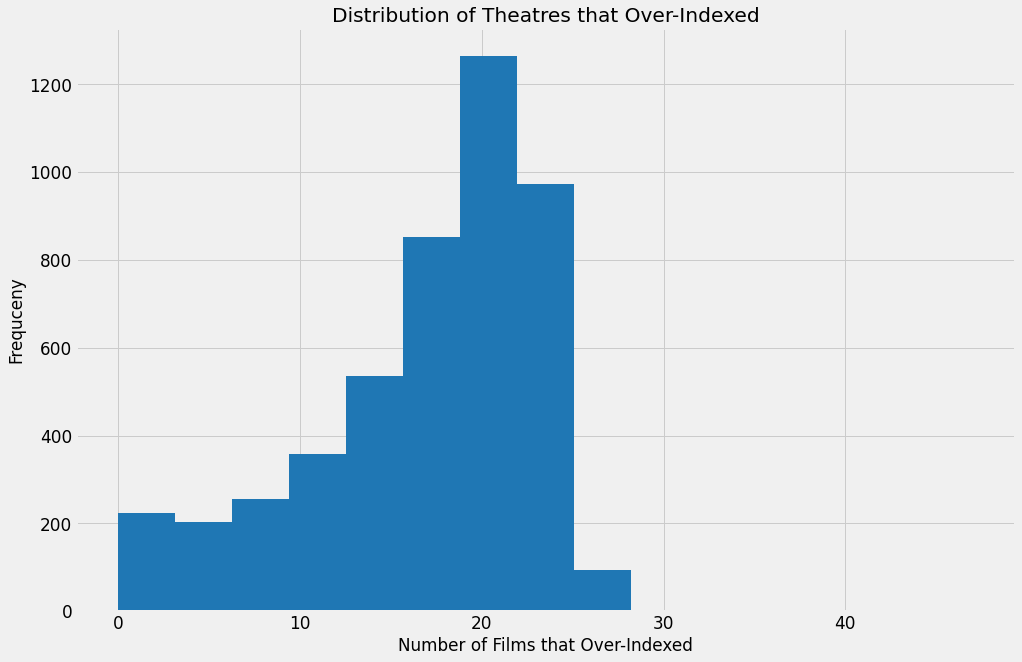

In [562]:
fig, ax = plt.subplots()
ax.hist(oi['over_indexcount'],bins=15,color='tab:blue')
ax.set_xlabel('Number of Films that Over-Indexed')
ax.set_ylabel('Frequceny')
ax.set_title('Distribution of Theatres that Over-Indexed')

In [958]:
ow_data

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total
0,1.0,2017-10-05,BLADE RUNNER 2049,2D,Cupid Live Cinemas,417.00,129.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,39806368
1,1.0,2017-08-25,DUNKIRK (2017),2D,Cupid Live Cinemas,400.00,0.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,61980778
2,1.0,2017-10-20,IT (2017),2D,Cupid Live Cinemas,559.00,172.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,146409865
3,1.0,2017-02-10,"LEGO BATMAN MOVIE, THE",2D,Cupid Live Cinemas,3134.00,1035.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,56793423
4,1.0,2017-09-22,"LEGO NINJAGO MOVIE, THE",2D,Cupid Live Cinemas,958.00,340.0,"Mills, Thompson and Rollins","Smith, Miller and Miller",Morales-Hansen,Normal,EASTERN,INDIANAPOLIS,"ALEXANDRIA, IN",FIRST RUN,22677891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,2018-09-28,SMALLFOOT,2D,Earnings Cause Movies,538.21,116.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27012067
205420,1.0,2018-10-05,"STAR IS BORN, A (2024779)",2D,Earnings Cause Movies,623.02,94.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,70240763
205421,1.0,2018-03-16,TOMB RAIDER,2D,Earnings Cause Movies,927.94,143.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,27926483
205422,1.0,2017-05-12,UNFORGETTABLE,2D,Earnings Cause Movies,283.50,42.0,"Lee, Walls and Norman","Wilson, Walsh and Scott",Rojas-Chen,Normal,SOUTHERN,ATLANTIC ISLES,"FREEPORT GRAND BAHAMA, BI",FIRST RUN,6497468


In [362]:
# About 80,000 records Over Indexed
over_index = iter4[iter4['over_index'] ==1]

In [758]:
baseline

,over_index,# of Runs,budget,runtime,Boxoffice_Total,OW to YT,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN
0,0,4058,150000000,164,39806368,0.906,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0
1,0,3720,100000000,107,61980778,1.177,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0,4103,35000000,135,146409865,2.436,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0,4088,80000000,104,56793423,1.697,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,4047,70000000,101,22677891,1.317,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,0,4131,80000000,96,27012067,2.265,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
205420,0,3686,36000000,136,70240763,4.047,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
205421,0,3854,94000000,118,27926483,1.250,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
205422,0,2417,12000000,100,6497468,0.888,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0


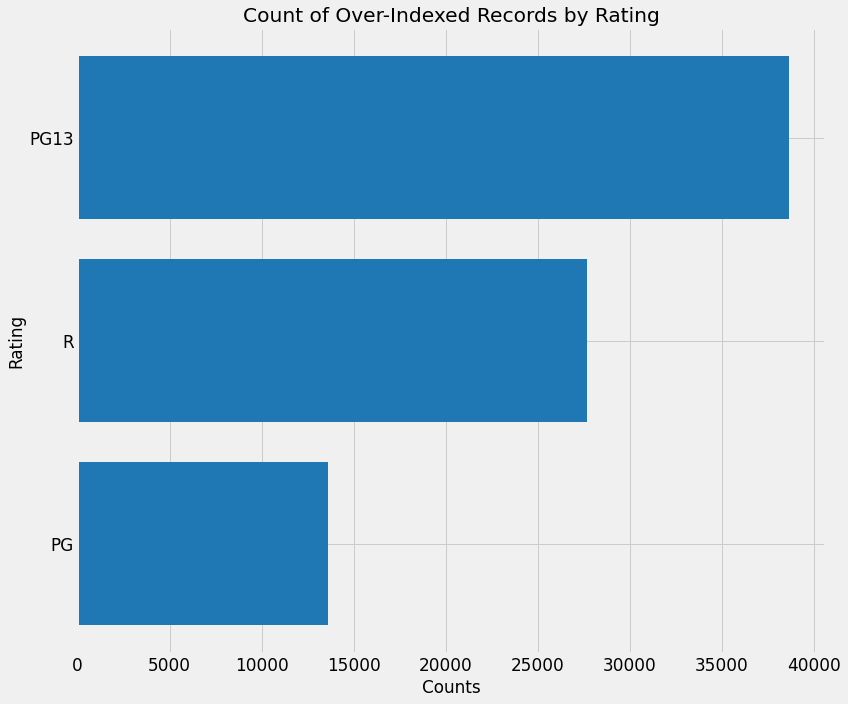

In [923]:
fig, ax = plt.subplots(figsize=(12,10))

ax.barh(over_index['Rating'].value_counts().sort_values().index,
        over_index['Rating'].value_counts().sort_values(),
        color='tab:blue')
ax.set_ylabel('Rating')
ax.set_xlabel('Counts')
ax.set_title('Count of Over-Indexed Records by Rating')
fig.tight_layout()
fig.show()

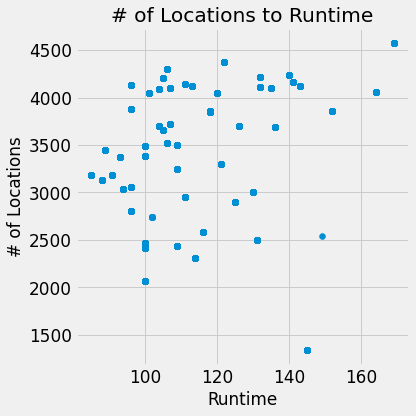

In [394]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(over_index['runtime'],over_index['# of Runs'])
ax.set_ylabel('# of Locations')
ax.set_xlabel('Runtime')
ax.set_title('# of Locations to Runtime')
fig.tight_layout()
fig.show()

# Modelling 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished


LR: Recall Score - 0.6735
DT: Recall Score - 0.7053
RF: Recall Score - 0.7053
GB: Recall Score - 0.7018


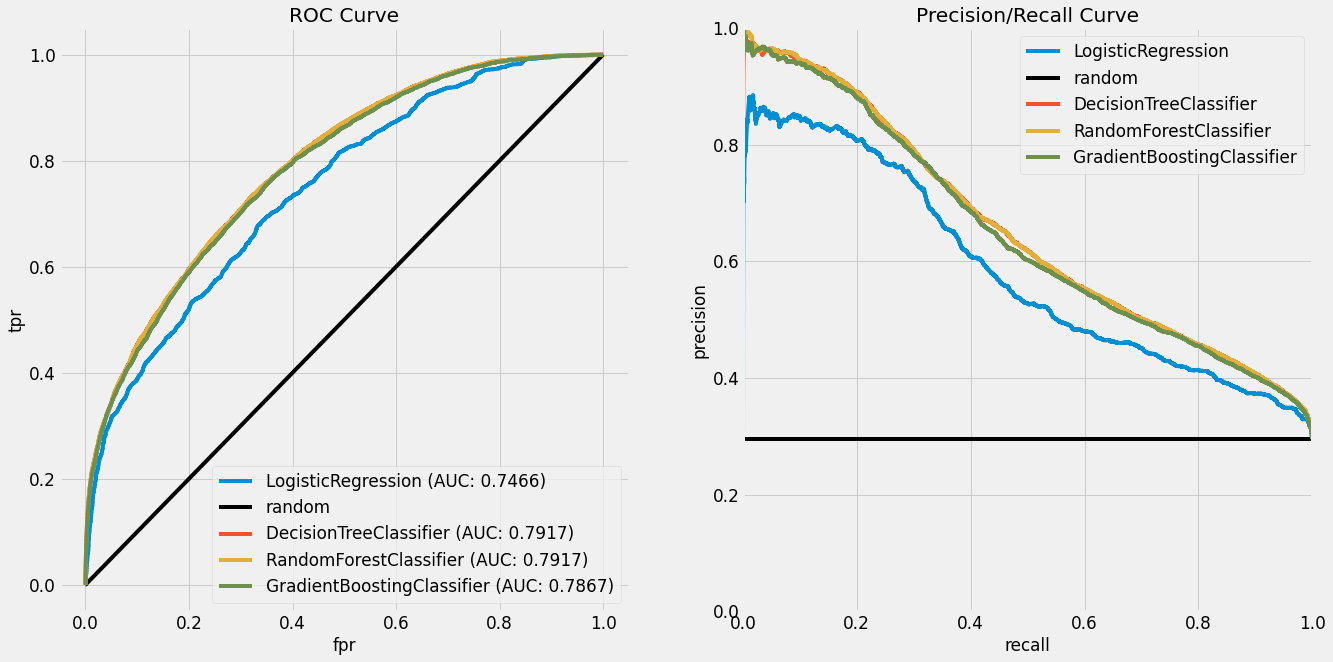

In [789]:
y = iter2_1hot['over_index']
X = iter2_1hot.drop(columns=['over_index'])
plot_models(X,y)

In [792]:
scale = StandardScaler()
runs = iter4_1hot['# of Runs']
transform = scale.fit_transform(runs.values.reshape(-1,1))
iter4_1hot['# of Runs'] = transform

In [942]:
y = iter4_1hot['over_index']
X = iter4_1hot.drop(columns=['over_index'])
#plot_models(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


LR: Recall Score - 0.6411
DT: Recall Score - 0.6885
RF: Recall Score - 0.6885
GB: Recall Score - 0.6853


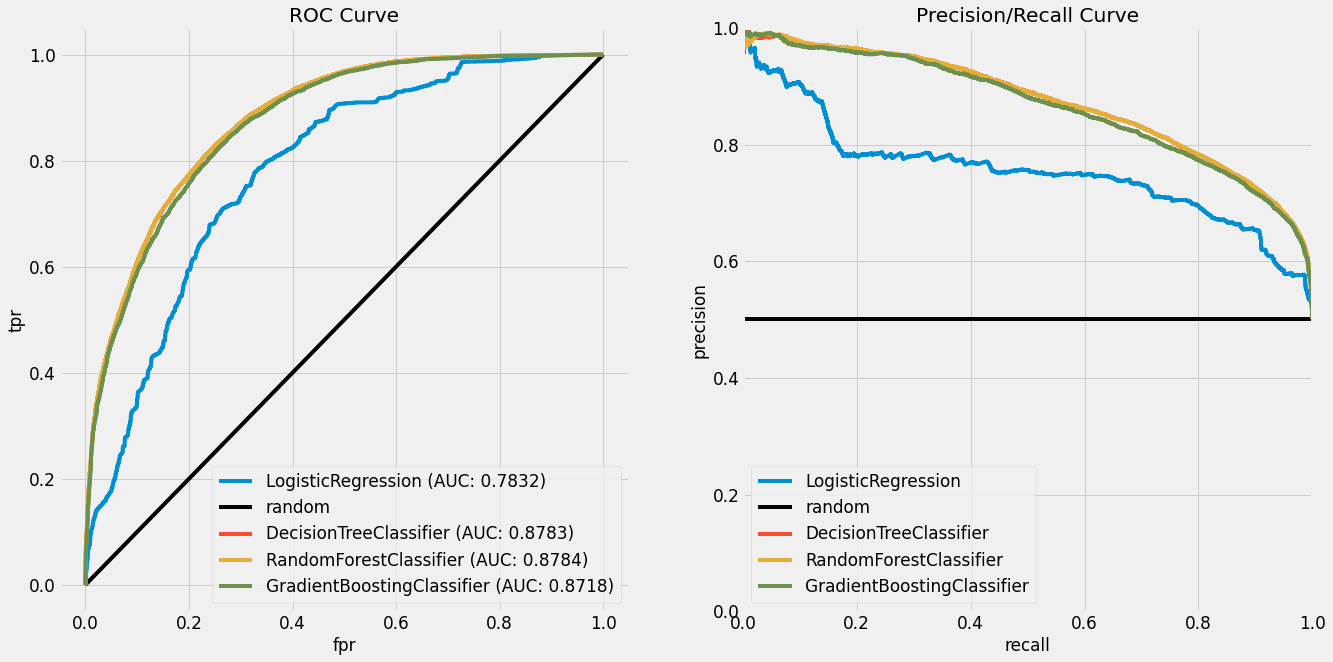

In [926]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

plot_models(X_under,y_under)

In [1097]:
X_train_val,X_unseen, y_train_val, y_unseen = train_test_split(X,y,random_state=42)
X_train,X_test, y_train, y_test = train_test_split(X_train_val,y_train_val,random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1098]:
#Logistic Regression
log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test).round(3)
log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s finished


In [805]:
# Decision Tree
dt_grid = {'max_depth': [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2,5, 10],
            'min_samples_leaf': [2, 5, 7],
            'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='recall')
dt_gridsearch.fit(X_train, y_train)
print("Best parameters:", dt_gridsearch.best_params_)
dt_model = dt_gridsearch.best_estimator_

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 1}


In [1099]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5,max_features='sqrt',min_samples_leaf=2,min_samples_split=2,random_state=1)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       random_state=1)

In [1100]:
y_pred_dt = dt_model.predict_proba(X_test).round(3)
dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)

In [808]:
# Random Forest
rf_grid = {'max_depth': [2, 5, 7],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 10],
            'min_samples_leaf': [2, 4, 8],
            'n_estimators': [100, 150],
            'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

rf_gridsearch.fit(X_train, y_train)
print("Best parameters:", rf_gridsearch.best_params_)
rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 1}


In [1101]:
# Random Forest

rf_model = RandomForestClassifier(max_depth=7, 
                                  max_features='sqrt', 
                                  min_samples_leaf=8, 
                                  min_samples_split=2,
                                  n_estimators=150,
                                  random_state=1,
                                  verbose=True)

rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.0s finished


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=8,
                       n_estimators=150, random_state=1, verbose=True)

In [1102]:
y_pred_rf = rf_model.predict_proba(X_test).round(3)
rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished


In [1114]:
# Gradient Boosting
gb_grid = {'learning_rate': [0.01, 0.05, 0.02],
              'max_depth': [2,4],
              'min_samples_leaf': [2,6,10],
              'n_estimators': [50, 100,200],
              'random_state': [1]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')
gb_gridsearch.fit(X_train, y_train)
print("Best parameters:", gb_gridsearch.best_params_)
gb_model = gb_gridsearch.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 6, 'n_estimators': 200, 'random_state': 1}


In [1115]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.05, 
                                      max_depth=4, 
                                      min_samples_leaf=6,
                                      n_estimators=200,
                                      random_state=1,
                                      verbose=True)
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3040           25.55s
         2           1.2729           26.04s
         3           1.2448           25.72s
         4           1.2192           25.48s
         5           1.1963           25.39s
         6           1.1748           25.14s
         7           1.1546           24.90s
         8           1.1369           24.76s
         9           1.1197           24.68s
        10           1.1042           24.71s
        20           0.9988           23.40s
        30           0.9442           22.15s
        40           0.9126           21.21s
        50           0.8963           19.90s
        60           0.8851           18.62s
        70           0.8775           17.29s
        80           0.8723           15.93s
        90           0.8679           14.58s
       100           0.8645           13.24s
       200           0.8502            0.00s


GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=6,
                           n_estimators=200, random_state=1, verbose=True)

In [1116]:
y_pred_gb = gb_model.predict_proba(X_test).round(3)
gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)

Unseen GB: Recall Score - 0.7284
GB: Recall Score - 0.7305


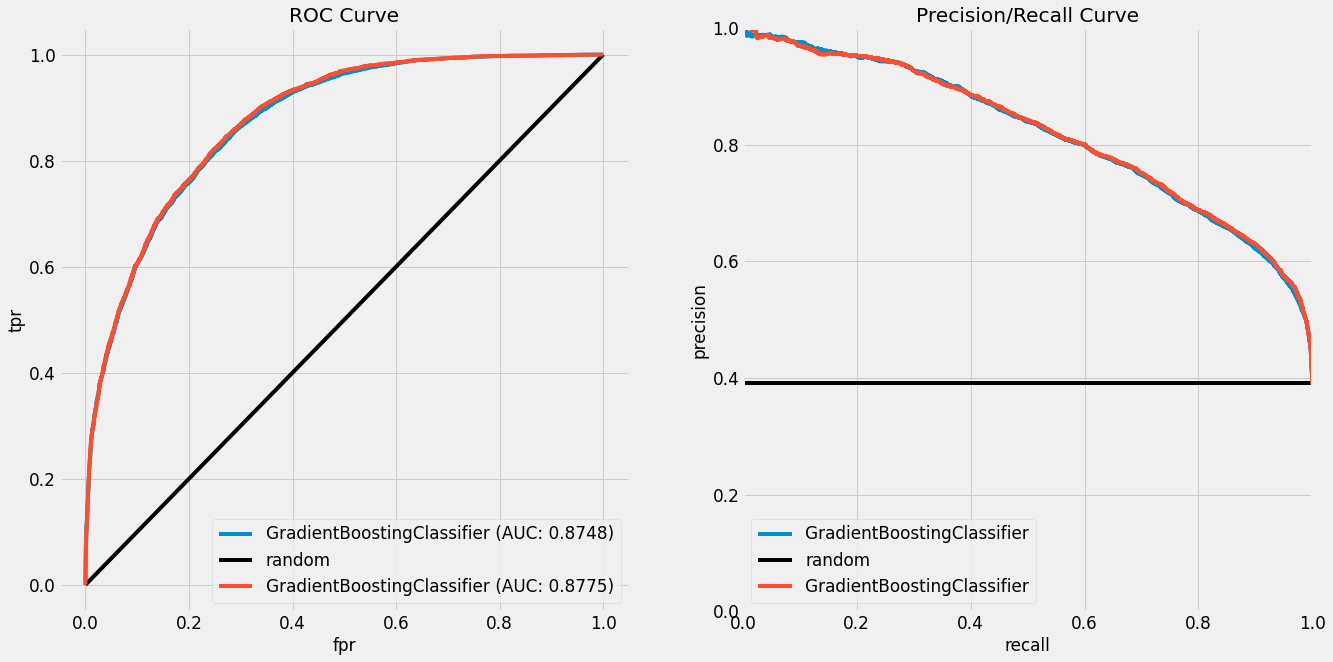

In [1117]:
unseen_gb_df = calculate_threshold_values(gb_model.predict_proba(X_unseen)[:, 1], y_unseen)

print('Unseen GB: Recall Score - {:.4f}'.format(unseen_gb_df['tpr'].mean()))
print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, unseen_gb_df,gb_model,True)
plot_roc(ax1, gb_df,gb_model)
plot_precision_recall(ax2, unseen_gb_df,gb_model,True)
plot_precision_recall(ax2, gb_df,gb_model)

In [107]:
def plot_precision_recall(ax, df, model, random=False):
    label = type(model).__name__ 
    ax.plot(df.tpr,df.precision, label=label)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    if random:
        ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend()

In [1105]:
'''
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_model.score(X_test,y_test)))
print('RF: Recall Score - {:.4f}'.format(rf_model.score(X_test,y_test)))
print('GB: Recall Score - {:.4f}'.format(gb_model.score(X_test,y_test)))


print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(recall_score(y_test, dt_model.predict(X_test))))
print('RF: Recall Score - {:.4f}'.format(recall_score(y_test, rf_model.predict(X_test))))
print('GB: Recall Score - {:.4f}'.format(recall_score(y_test, gb_model.predict(X_test))))
'''
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_df['tpr'].mean()))
print('RF: Recall Score - {:.4f}'.format(rf_df['tpr'].mean()))
print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))



LR: Recall Score - 0.6782
DT: Recall Score - 0.6917
RF: Recall Score - 0.7274
GB: Recall Score - 0.7321


In [786]:
def plot_models(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Logistic Regression
    log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict_proba(X_test).round(3)
    log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)
    
    # Decision Tree
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict_proba(X_test).round(3)
    dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)
    
    # Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict_proba(X_test).round(3)
    rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)
    
    # Gradient Boosting
    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict_proba(X_test).round(3)
    gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)
    
    print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
    print('DT: Recall Score - {:.4f}'.format(dt_df['tpr'].mean()))
    print('RF: Recall Score - {:.4f}'.format(rf_df['tpr'].mean()))
    print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    plot_roc(ax1, log_reg_df,log_reg,True)
    plot_roc(ax1, dt_df,dt_model)
    plot_roc(ax1, rf_df,rf_model)
    plot_roc(ax1, gb_df,gb_model)


    plot_precision_recall(ax2, log_reg_df,log_reg,True)
    plot_precision_recall(ax2, dt_df,dt_model)
    plot_precision_recall(ax2, rf_df,rf_model)
    plot_precision_recall(ax2, gb_df,gb_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LR: Recall Score - 0.4436
DT: Recall Score - 0.4021
RF: Recall Score - 0.4026
GB: Recall Score - 0.3700


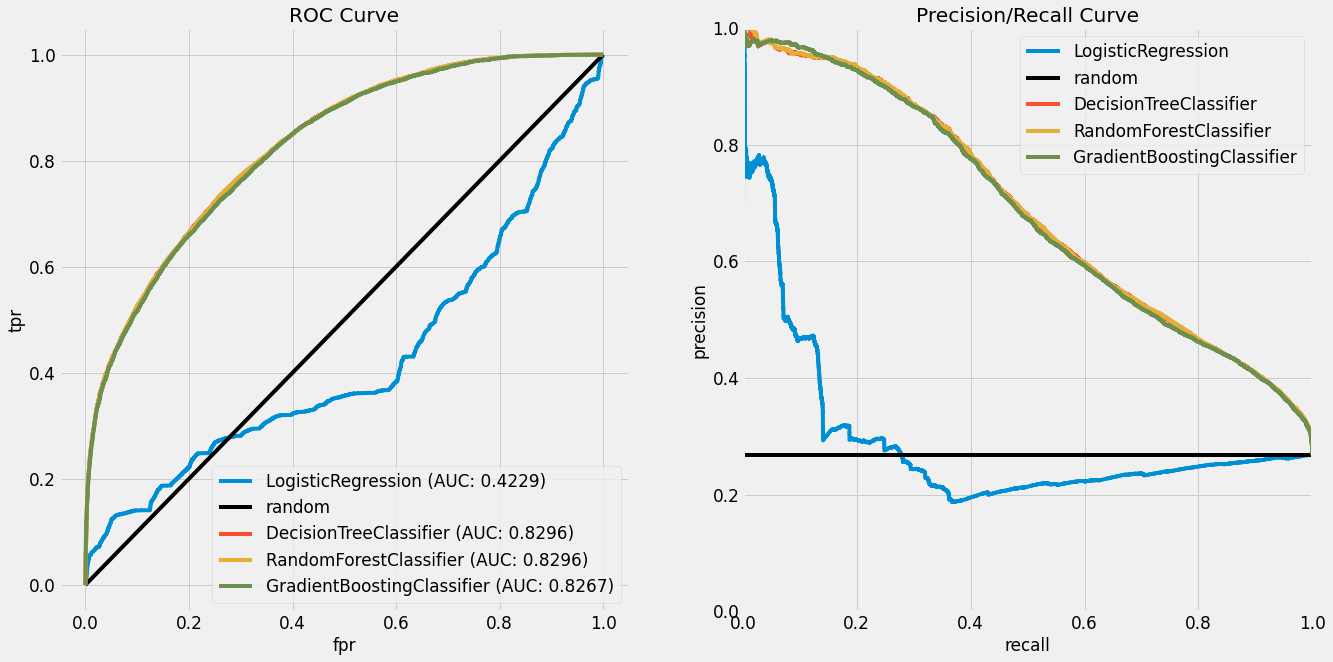

In [597]:
y = baseline['over_index']
X = baseline.drop('over_index',axis=1)
plot_models(X,y)

# ROC Curve, Precision/Recall Curve, and Confusion Matrix

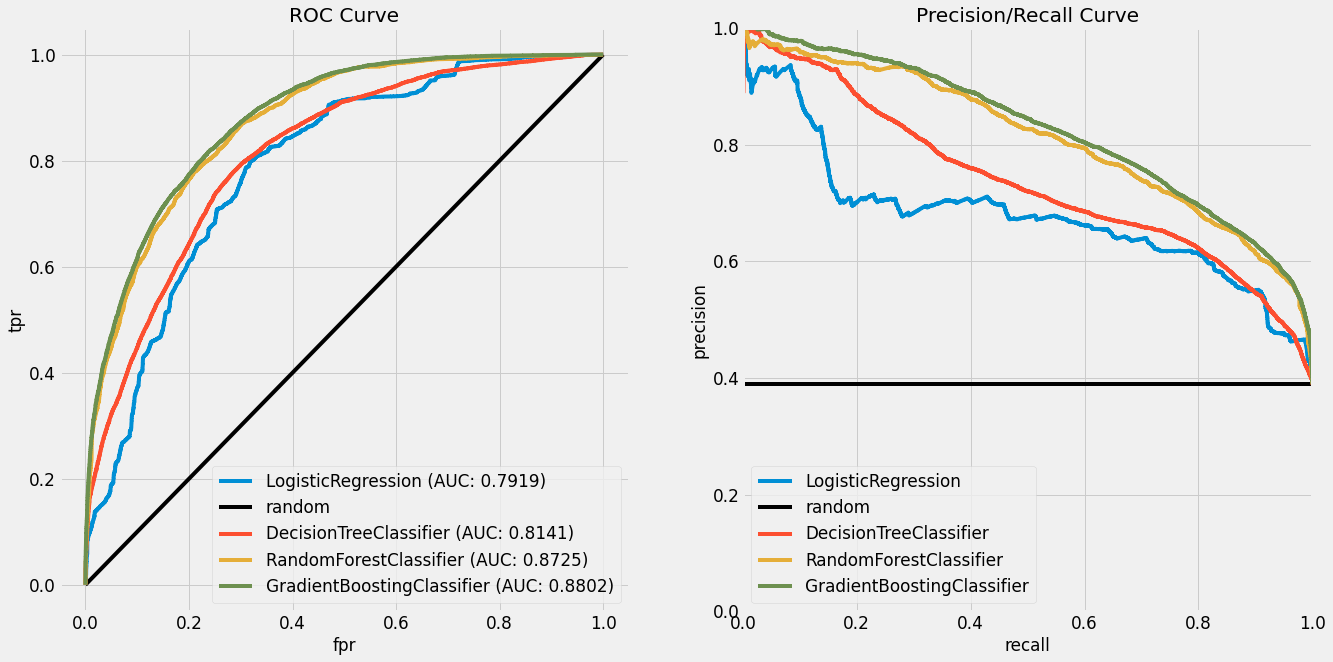

In [1106]:
#ROC Curve
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, log_reg_df,log_reg,True)
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)


plot_precision_recall(ax2, log_reg_df,log_reg,True)
plot_precision_recall(ax2, dt_df,dt_model)
plot_precision_recall(ax2, rf_df,rf_model)
plot_precision_recall(ax2, gb_df,gb_model)

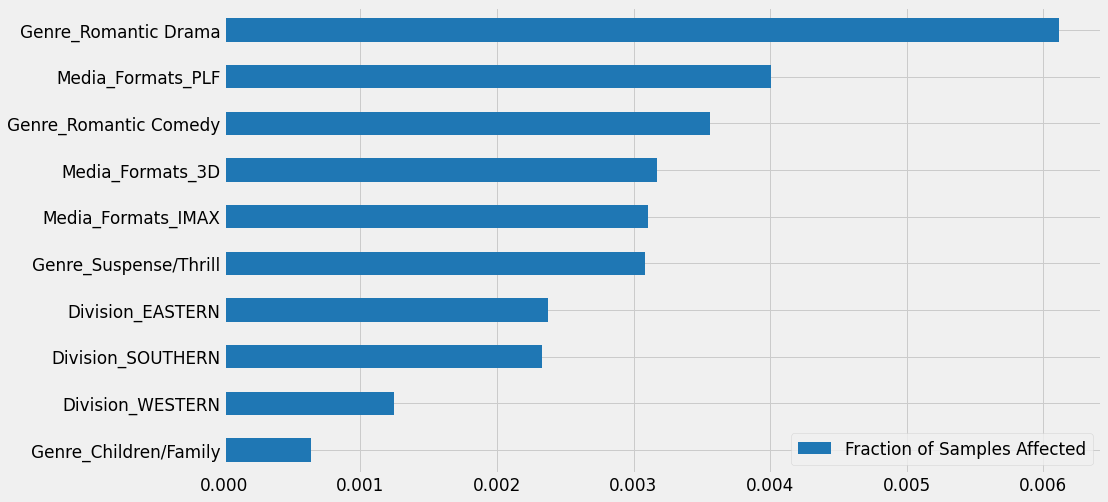

In [1096]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected').head(10)
feat_scores.plot(kind='barh', figsize = (14,8),color='tab:blue');

In [948]:
rf_df.columns

Index(['prob', 'y', 'tn', 'fn', 'fp', 'tp', 'fpr', 'tpr', 'precision'], dtype='object')

<AxesSubplot:>

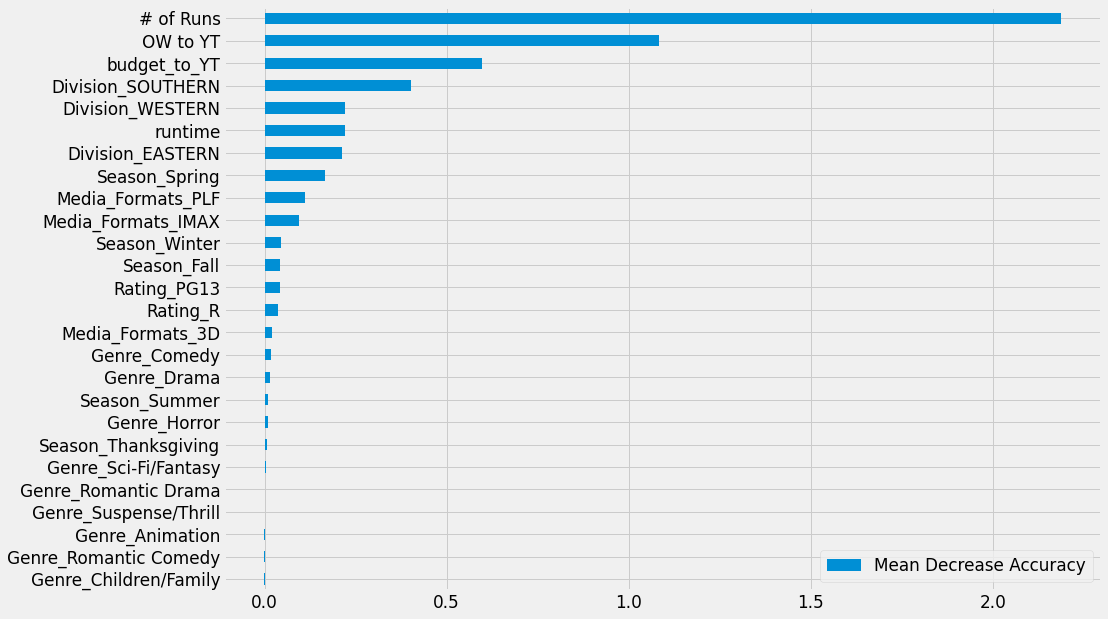

In [951]:
# manual shuffle 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

rf = RandomForestClassifier()
scores = defaultdict(list)


names = X.columns
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in tqdm(splitter.split(X, y)):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in tqdm(range(X.shape[1])):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10))

<AxesSubplot:>

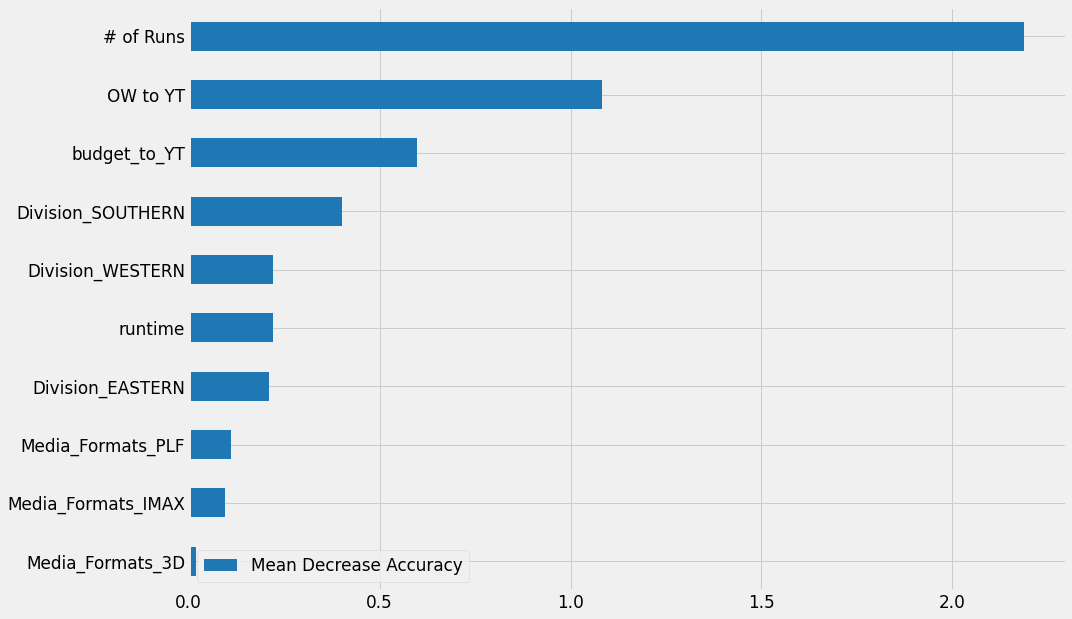

In [1094]:
abs(scores).head(10).sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10),color='tab:blue')

Text(0.5, 1.0, 'Confusion Matrix with 50% Threshold')

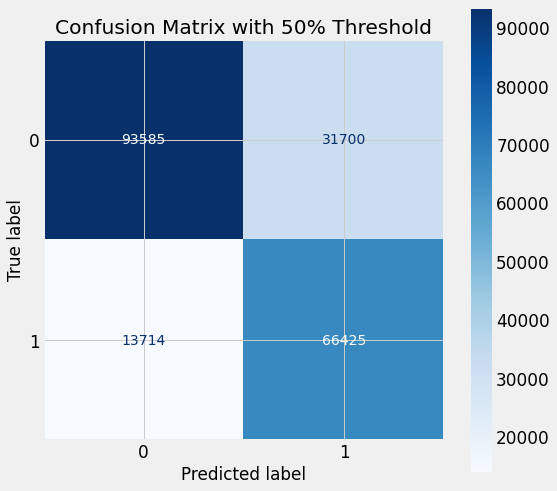

In [830]:
# How to identify proper threshold?
cm = confusion_matrix1(gb_model, X,y, 0.5)

fig, ax = plt.subplots(figsize = (8,8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy())
disp.plot(cmap = plt.cm.Blues, ax = ax)
ax.set_title('Confusion Matrix with 50% Threshold')

In [344]:
cities = df.groupby(['Division','Theatre','City'],as_index=False).last()
cities = cities[cities['Division'] != 'CANADIAN']
cities = cities.groupby(['Theatre','City'],as_index=False).first()[['Theatre','City']]
cities

,Theatre,City
0,About Archive Forum,"DURHAM, NC"
1,About Bevy Flicks,"PERRY, IA"
2,About Bold Forum,"WAYNE, NJ"
3,About Crypt Flicks,"MILAN, TN"
4,About Discover Cinemas,"BEVERLY HILLS, CA #3 LOS ANGEL"
...,...,...
5705,for Promotions Flicks,"PEMBROKE PINES, FL #2"
5706,for Pure Cinemas,"HASTINGS, MI"
5707,for Radical Theaters,"RUSHVILLE, IN"
5708,for Ratchet Marquee,"NOBLESVILLE, IN"


In [352]:
cities_list = cities['City'].unique().tolist()
city_list = []
for city in tqdm(cities_list):
    city_list.append(str(city).split('#')[0])
cities_dict = dict.fromkeys(city_list)


In [353]:
cities_dict

{'DURHAM, NC': None,
 'PERRY, IA': None,
 'WAYNE, NJ': None,
 'MILAN, TN': None,
 'BEVERLY HILLS, CA ': None,
 'BOTTINEAU, ND': None,
 'FT WORTH, TX': None,
 'MESA, AZ': None,
 'WAYNESVILLE, NC': None,
 'BEDFORD VILLAGE, NY': None,
 'CHECOTAH, OK': None,
 'ATHENS, GA': None,
 'ONEIDA, NY': None,
 'FALMOUTH, MA': None,
 'POOLER, GA': None,
 'HARMONY, MN': None,
 'ALHAMBRA, CA': None,
 'RAVENNA, OH': None,
 'DANVILLE, IN': None,
 'FOOTHILL RANCH, CA': None,
 'EAU CLAIRE, WI': None,
 'CHARLEVOIX, MI': None,
 'MC COOK, NE': None,
 'WEST BRANCH, MI': None,
 'MEMPHIS, TN ': None,
 'HICKORY, NC': None,
 'BALTIMORE, MD ': None,
 'CINCINNATI, OH ': None,
 'NEWPORT, RI': None,
 'BOWLING GREEN, KY': None,
 'AGOURA HILLS, CA': None,
 'DICKSON CITY, PA': None,
 'ALLIANCE, NE': None,
 'BRENTWOOD, CA': None,
 'DULUTH, MN': None,
 'VICKSBURG, MS': None,
 'NEW YORK, NY ': None,
 'AURORA, OH': None,
 'MOAB, UT': None,
 'MOLINE, IL': None,
 'LAKESIDE, OH': None,
 'RICHFIELD, UT': None,
 'ROXBORO, NC': No

In [251]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from geopy.geocoders import Nominatim

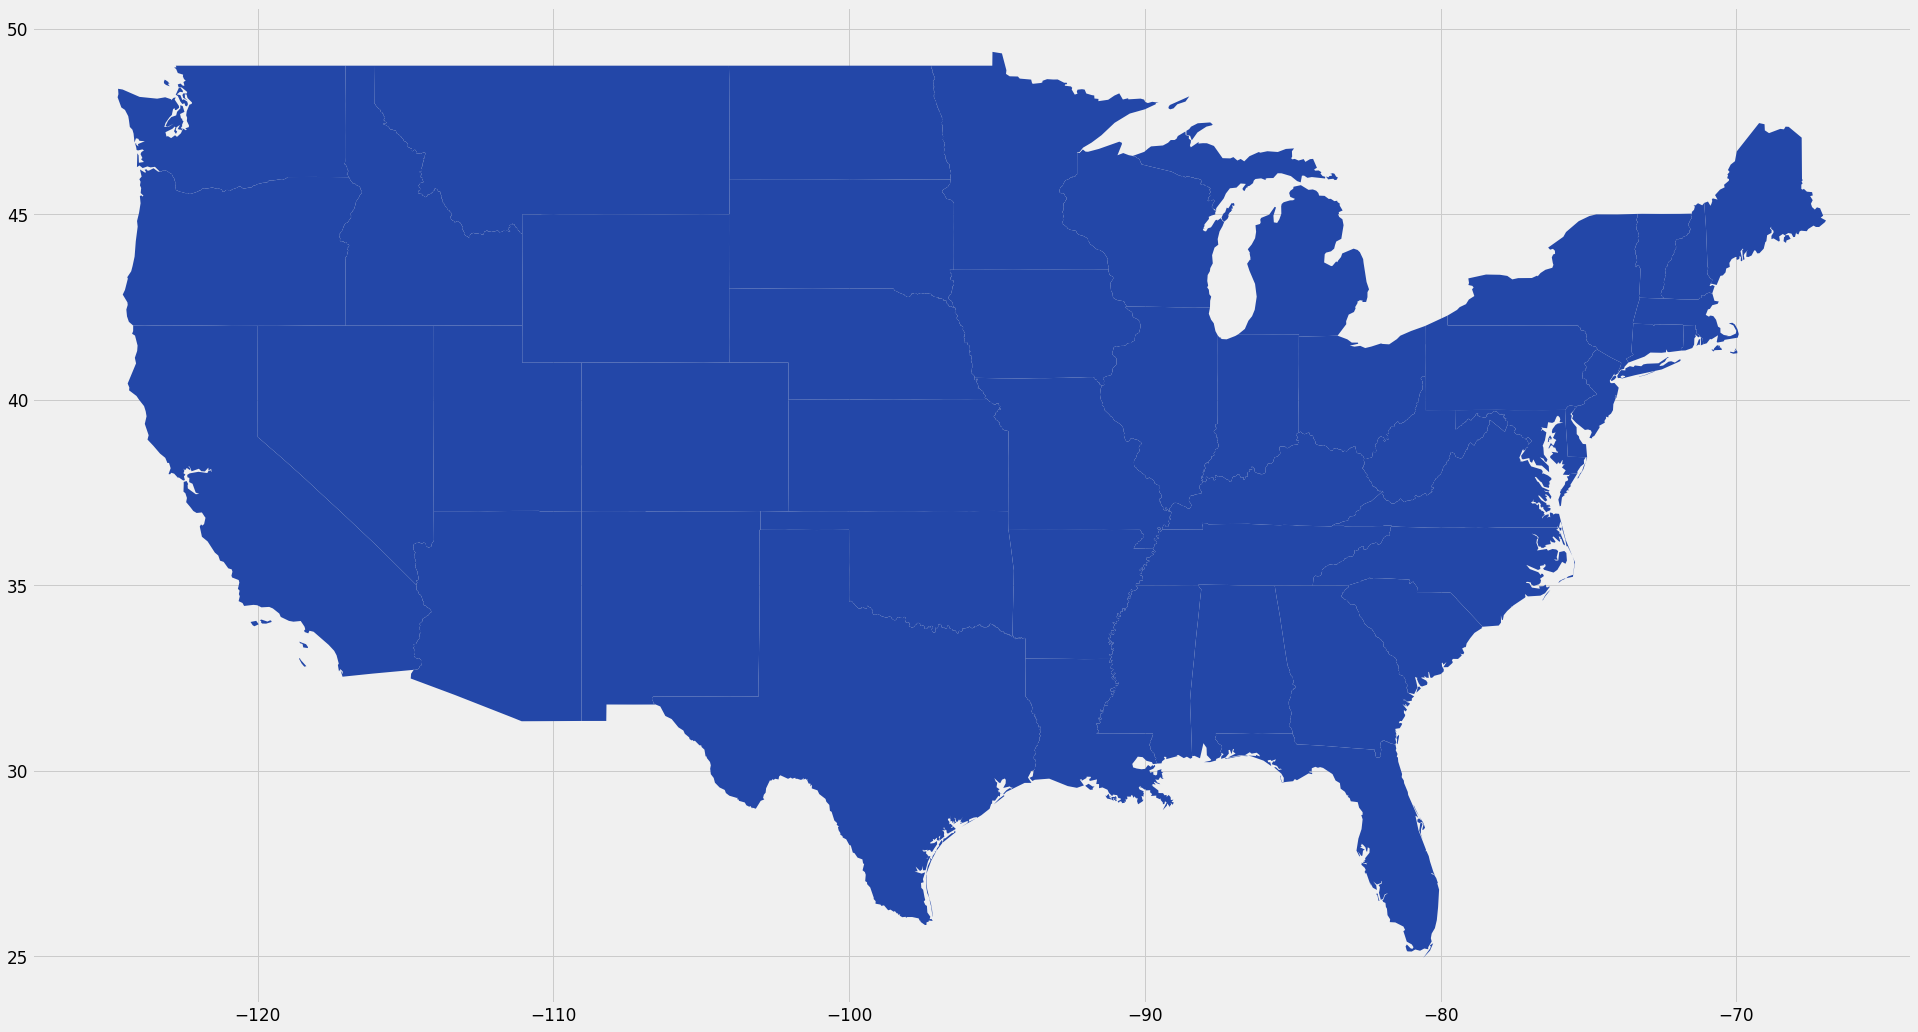

In [1003]:
usa = gpd.read_file("data/States_shapefile.shp")
usa = usa[['State_Code','geometry']]
usa = usa[usa['State_Code'].isin(['AK','HI']) == False]
usa.plot(figsize=(30,20), color='#2347a8');


In [354]:
#RUN THIS LATER THIS EVENING
from geopy import geocoders

geolocator = Nominatim(user_agent="over_under_theatres.ipynb")
lat=[]
long=[]

def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
          
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="over_under_theatres.ipynb")
          
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    


for key,value in tqdm(cities_dict.items()):
    if findGeocode(key) != None:
           
        loc = findGeocode(key)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        cities_dict[key] = (loc.longitude,loc.latitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        cities_dict[key] = (np.nan, np.nan)
        
        
    #usa.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(count))*scale)
#plt.show()

NameError: name 'GeocoderTimedOut' is not defined

In [301]:
city_df = pd.DataFrame.from_dict(cities_dict, orient='index').reset_index()
city_df.columns = ['City','Long','Lat']
city_df.set_index('City',inplace=True)

In [307]:
city_df.iloc[0][0]

-1.75

In [315]:
gdf = gpd.GeoDataFrame(
    city_df, geometry=gpd.points_from_xy(city_df.Long, city_df.Lat))

In [1070]:
gdf_=gdf.reset_index()

In [1016]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [1071]:
gdf_

,City,Long,Lat,geometry
0,DURHAM,-1.750000,54.666667,POINT (-1.75000 54.66667)
1,"PERRY, IA",-94.106762,41.838670,POINT (-94.10676 41.83867)
2,"PASSAIC COUNTY, NJ",-74.317793,41.046186,POINT (-74.31779 41.04619)
3,"MILAN, TN",-88.758949,35.919789,POINT (-88.75895 35.91979)
4,"LOS ANGELES, CA",-118.242766,34.053691,POINT (-118.24277 34.05369)
...,...,...,...,...
2394,"KENT, OH",-81.357886,41.153667,POINT (-81.35789 41.15367)
2395,"GARRETTSVILLE, OH",-81.096486,41.284222,POINT (-81.09649 41.28422)
2396,"WYNNE, AR",-90.786780,35.224533,POINT (-90.78678 35.22453)
2397,"LEWISBURG, TN",-86.788889,35.449240,POINT (-86.78889 35.44924)


In [1048]:
pred = (rf_model.predict_proba(X_test).round(3)[:,1])
type(pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


numpy.ndarray

In [1093]:
theatre_list = ow_data.groupby('Theatre',as_index=False).first()
theatre_list = theatre_list[['Theatre','Film_Buyer','Buying_Circuit','Payer']].sample(20)
theatre_list['Prob'] = np.random.choice(pred,size=20)
theatre_list.sort_values('Prob',inplace=True,ascending=False)
#theatre_list=theatre_list.merge(gdf_, how='left',on='City')
theatre_list.dropna(axis=0, inplace=True)
theatre_list.head(10)

,Theatre,Film_Buyer,Buying_Circuit,Payer,Prob
3507,Ment Blink Theaters,"Cole, Medina and Schultz",Wheeler-Smith,Wheeler-Smith,0.921
4032,Perfect Dawn Marquee,"Lewis, Ferguson and Bauer",Richards LLC,Ayala Ltd,0.845
3544,Miner Energise Cinemas,Gomez LLC,Ruiz Group,"Weber, Nelson and Navarro",0.706
898,Capital Dart Cinemas,Murray-Ayala,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",0.692
1944,Exciting Jump Cinemas,Odonnell LLC,Wheeler-Smith,Wheeler-Smith,0.685
3293,Made Ment Screens,Sampson-Ferguson,Brown-Davenport,Brown-Davenport,0.685
3639,Muno Programs Screens,Gomez LLC,Ruiz Group,"Guerrero, Pierce and Mccormick",0.658
4514,Radiant Dash Screens,Kelly LLC,Rogers Ltd,"Stewart, Sims and Robinson",0.650
1744,Dynamic Wave Cinemas,"Greene, Barrera and Chan",Chang-Moore,"Perkins, Smith and Diaz",0.645
3334,Magnolia Peta Forum,"Ellis, Jennings and Schmidt","Rodriguez, Barron and Hughes",Mcintyre-Gibson,0.645


In [1080]:
sample = gdf.sample(10)

(-127.62094470830219, -64.0810960992263, 23.735608737433875, 50.59249782231722)

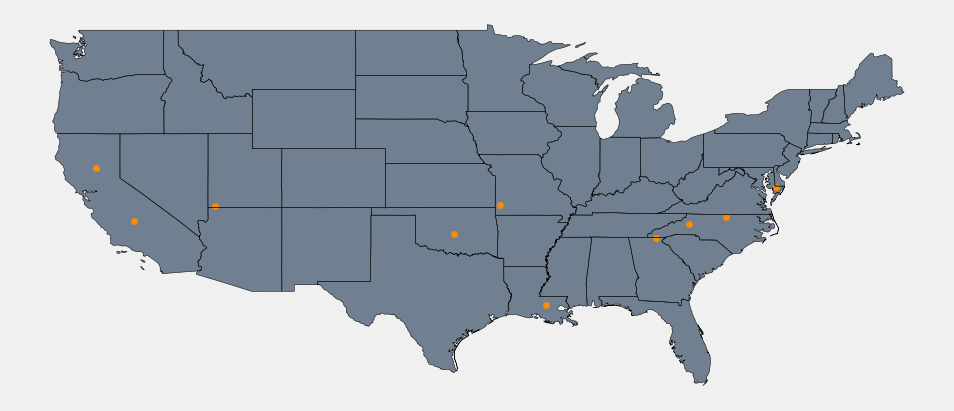

In [1081]:
fig, ax = plt.subplots(1,1)
base = usa[usa['State_Code'].isin(['AK','HI']) == False].plot(ax=ax, color='slategrey')
usa.boundary.plot(ax=ax,linewidth=0.5,color='black')
sample.plot(ax=base, color='darkorange', marker="o", markersize=40)

plt.axis('off')

# Clustering Data

In [616]:
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [617]:
def plot_elbow_sil(df,maxk):
    maxk = maxk
    wcss = []
    sil_scores = []
    for i in tqdm(range(2, maxk)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
        kmeans.fit(df)
        ypred=kmeans.predict(df)
        wcss.append(kmeans.inertia_)    
        labels = kmeans.labels_
        
        score = silhouette_score(df, labels, metric = 'euclidean')
        sil_scores.append(score)
    plt.plot(range(2, maxk), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot Plots
    fig, ax = plt.subplots(figsize=(maxk,10))
    ax.plot(range(2,maxk), sil_scores, 'o-')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette score")

In [669]:
full_movie.head(1)

,# of Runs,Genre,Rating,Season,budget,runtime,Boxoffice_Total,Film (Distributor),YT Trailer Views,OW to YT,budget_to_YT
0,2464,Comedy,R,Spring,25000000,100,10467132,CHIPS (2017),7.081,1.091,3.531


In [677]:
fm = full_movie.copy()
fm.set_index('Film (Distributor)',inplace=True)
fm.drop(['YT Trailer Views','budget_to_YT'],axis=1,inplace=True)
num_cols = fm.columns[fm.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
scale = StandardScaler()
fm[num_cols]=scale.fit_transform(fm[num_cols])
fm_1hot = pd.get_dummies(fm[['Genre','Season','Rating']],drop_first = True)
fm_1hot
fm_full = fm.join(fm_1hot,how='left')
fm_full = fm_full.drop(['Genre','Season','Rating'],axis=1)
fm_full

,# of Runs,budget,runtime,Boxoffice_Total,OW to YT,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R
Film (Distributor),,,,,,,,,,,,,,,,,,,,,
CHIPS (2017),-1.434362,-0.712037,-0.768135,-0.835831,-0.352320,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
"LEGO BATMAN MOVIE, THE",0.898109,0.189007,-0.563804,0.461075,0.057539,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
FIST FIGHT,-0.398825,-0.761185,-1.227881,-0.659116,-0.169710,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
UNFORGETTABLE,-1.501866,-0.925012,-0.768135,-0.946962,-0.489616,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
KONG: SKULL ISLAND,0.550536,1.909183,0.151357,0.912890,0.078505,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JOKER,1.308876,-0.220559,0.355688,2.334977,-0.513964,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
DOCTOR SLEEP (2019),0.563462,-0.384385,1.888175,-0.649206,-0.577540,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
MOTHERLESS BROOKLYN,-3.045835,-0.695655,1.530595,-0.984245,-0.743918,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


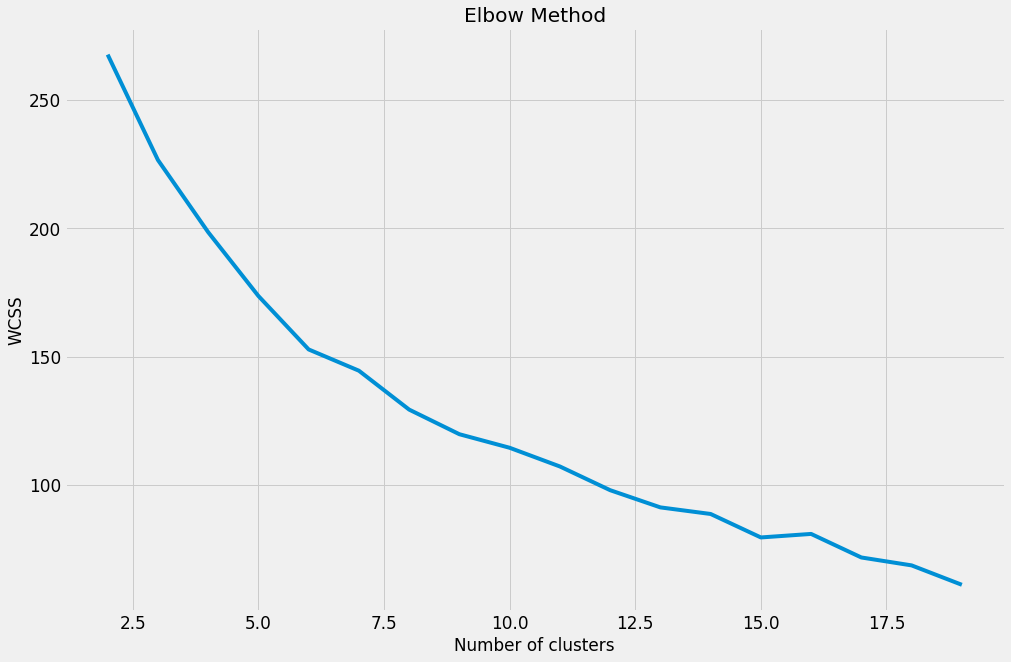

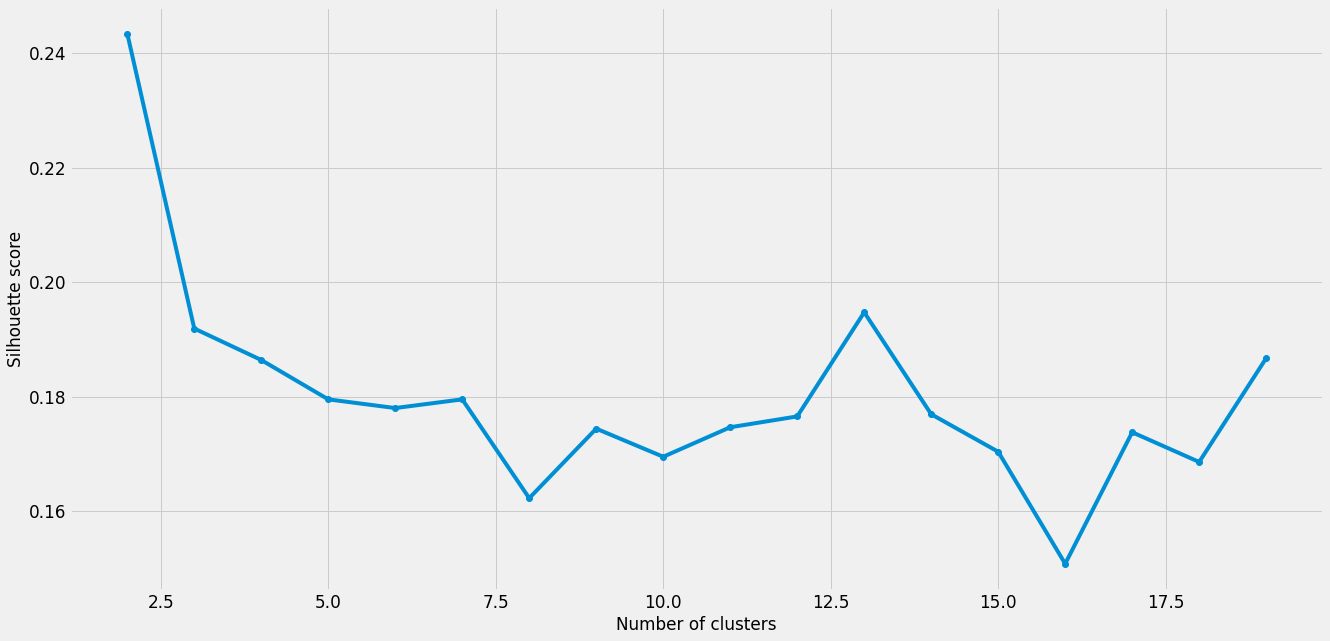

In [678]:
plot_elbow_sil(fm_full,20)

In [679]:
#Genre + Movie Clustering
fm_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fm_cluster.fit_predict(fm_full)
fm_full['clusters']=pred_y

cluster_test = fm_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

Film (Distributor)
BLINDED BY THE LIGHT (2083623)         0
SUN IS ALSO A STAR, THE                0
EVERYTHING, EVERYTHING                 0
MEG, THE                               1
GODZILLA: KING OF THE MONSTERS         1
KING ARTHUR: LEGEND OF THE SWORD       1
POKEMON DETECTIVE PIKACHU              1
CRAZY RICH ASIANS                      2
ISN'T IT ROMANTIC                      2
DUNKIRK (2017)                         2
OCEAN'S 8                              2
15:17 TO PARIS, THE                    3
LIFE OF THE PARTY                      3
GOING IN STYLE (2017)                  3
STAR IS BORN, A (2024779)              4
JOKER                                  4
IT (2017)                              4
BLADE RUNNER 2049                      5
DOCTOR SLEEP (2019)                    5
IT CHAPTER TWO                         5
CURSE OF LA LLORONA, THE               6
NUN, THE                               6
ANNABELLE COMES HOME                   6
ANNABELLE: CREATION                   

In [625]:
fm_num = fm.drop(['Genre','Season','Rating'],axis=1)

fm_std = (fm_num-np.mean(fm_num))/np.std(fm_num)
n_components = 2
fm_pca = PCA(n_components=n_components).fit_transform(fm_std.values)
fm_pca

array([[-1.84370467, -0.54627175],
       [ 0.60503682,  0.66464362],
       [-1.41923942,  0.20479644],
       [-2.03995684, -0.68174493],
       [ 1.83773568,  0.18222225],
       [-1.55405569,  1.76187087],
       [ 1.05025898, -0.90896586],
       [-1.77157129,  0.31861194],
       [ 3.1984239 , -0.14133375],
       [-1.40771395,  0.24306767],
       [ 0.6669368 ,  0.11545419],
       [-0.47537145,  0.33345898],
       [ 2.1763405 ,  0.8086869 ],
       [-0.07573962,  0.37964676],
       [ 2.11942023, -1.24199286],
       [-0.19635009, -0.32340647],
       [-1.08716649,  4.59924126],
       [ 3.74484076, -0.19446767],
       [-1.01191768, -1.29242862],
       [-0.67708368, -0.42710813],
       [-1.6230972 ,  2.37863387],
       [-0.84055946,  0.60368393],
       [ 0.39731549, -0.13739832],
       [ 2.34309905, -0.39687576],
       [ 0.82133981,  0.11934099],
       [-0.69983976,  0.91801297],
       [-0.99019721,  0.48926689],
       [ 0.64400555,  0.58726656],
       [-1.60490983,

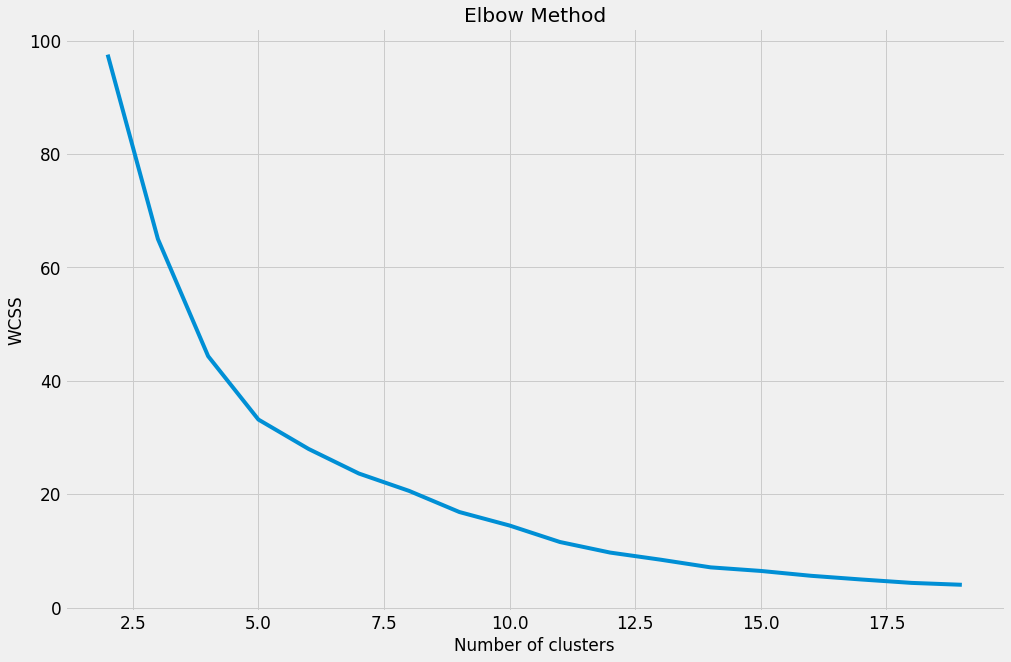

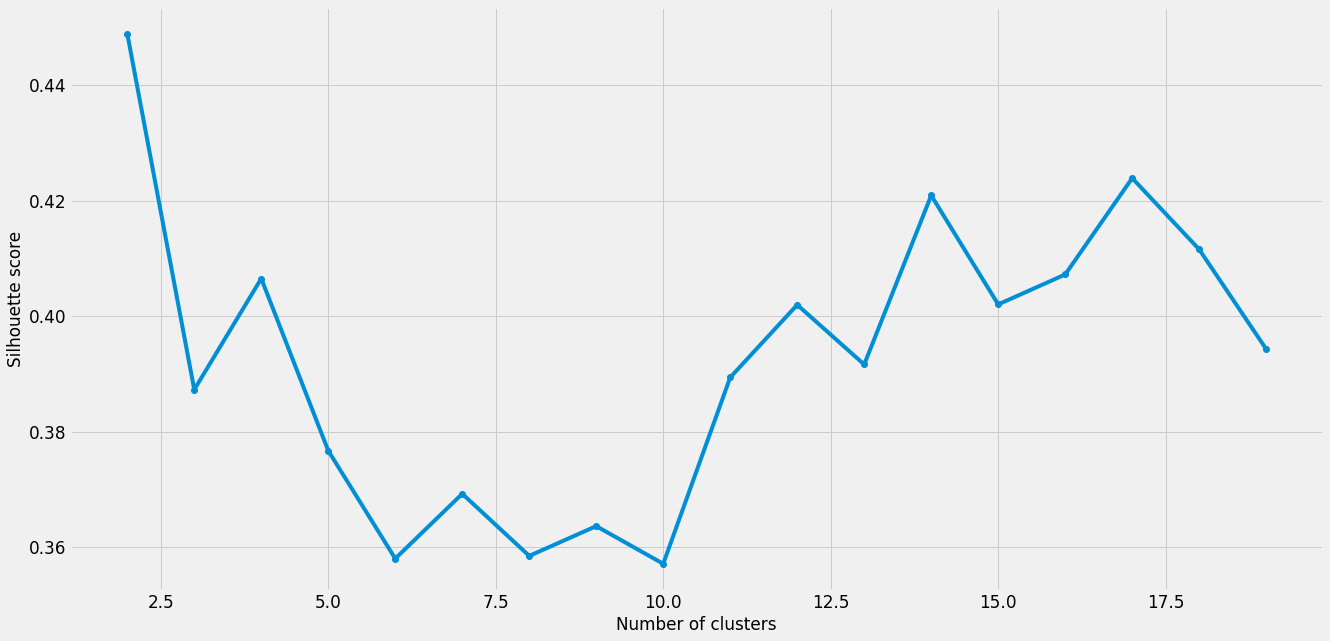

In [626]:
plot_elbow_sil(fm_pca,20)

Text(0, 0.5, 'Second Principal Component')

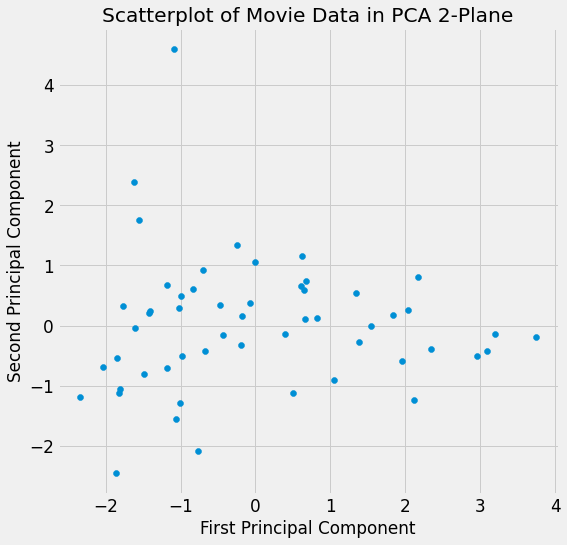

In [627]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(fm_pca[:, 0], fm_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [708]:
#Movie_PCA Clustering

fm_pca_df = pd.DataFrame(fm_pca, columns = ('PCA1','PCA2'))
fm_ = fm_full.copy().reset_index()
fm_pca_df = fm_.merge(fm_pca_df,how='left',left_index=True,right_index=True)
fm_pca_df.drop(['# of Runs','budget','runtime','Boxoffice_Total','OW to YT','clusters'],axis=1,inplace=True)
fm_pca_df.set_index('Film (Distributor)',inplace=True)
#plot_elbow_sil(fm_pca_df,25)

fmpca_cluster = KMeans(n_clusters=18, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fmpca_cluster.fit_predict(fm_pca)
fm_pca_df['clusters']=pred_y

cluster_test = fm_pca_df['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

#fm_pca_df

Film (Distributor)
LEGO BATMAN MOVIE, THE                 0
LEGO MOVIE 2, THE: THE SECOND PART     0
STAR IS BORN, A (2024779)              0
OCEAN'S 8                              0
RICHARD JEWELL                         1
GOLDFINCH, THE                         1
FATHER FIGURES                         1
GODZILLA: KING OF THE MONSTERS         2
READY PLAYER ONE                       2
BLADE RUNNER 2049                      2
GOING IN STYLE (2017)                  3
15:17 TO PARIS, THE                    3
CURSE OF LA LLORONA, THE               4
ISN'T IT ROMANTIC                      4
LIFE OF THE PARTY                      4
GAME NIGHT                             4
TAG (2018)                             4
TOMB RAIDER                            5
RAMPAGE (2018)                         5
DUNKIRK (2017)                         5
PADDINGTON 2                           6
EVERYTHING, EVERYTHING                 7
FIST FIGHT                             7
HOUSE, THE (2017)                     

In [860]:
fm_

,Film (Distributor),# of Runs,budget,runtime,Boxoffice_Total,OW to YT,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R,clusters
0,CHIPS (2017),-1.434362,-0.712037,-0.768135,-0.835831,-0.352320,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,12
1,"LEGO BATMAN MOVIE, THE",0.898109,0.189007,-0.563804,0.461075,0.057539,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10
2,FIST FIGHT,-0.398825,-0.761185,-1.227881,-0.659116,-0.169710,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,12
3,UNFORGETTABLE,-1.501866,-0.925012,-0.768135,-0.946962,-0.489616,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,7
4,KONG: SKULL ISLAND,0.550536,1.909183,0.151357,0.912890,0.078505,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,JOKER,1.308876,-0.220559,0.355688,2.334977,-0.513964,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,4
50,DOCTOR SLEEP (2019),0.563462,-0.384385,1.888175,-0.649206,-0.577540,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,5
51,MOTHERLESS BROOKLYN,-3.045835,-0.695655,1.530595,-0.984245,-0.743918,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,7
52,"GOOD LIAR, THE",-1.470268,-0.957777,-0.308389,-0.891795,-0.743242,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,7


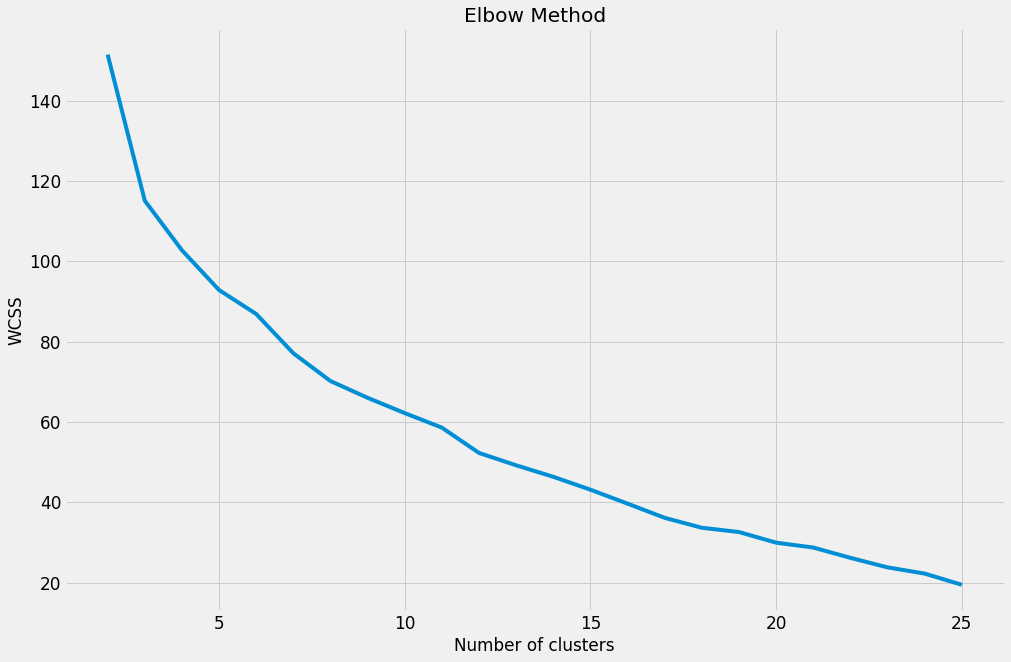

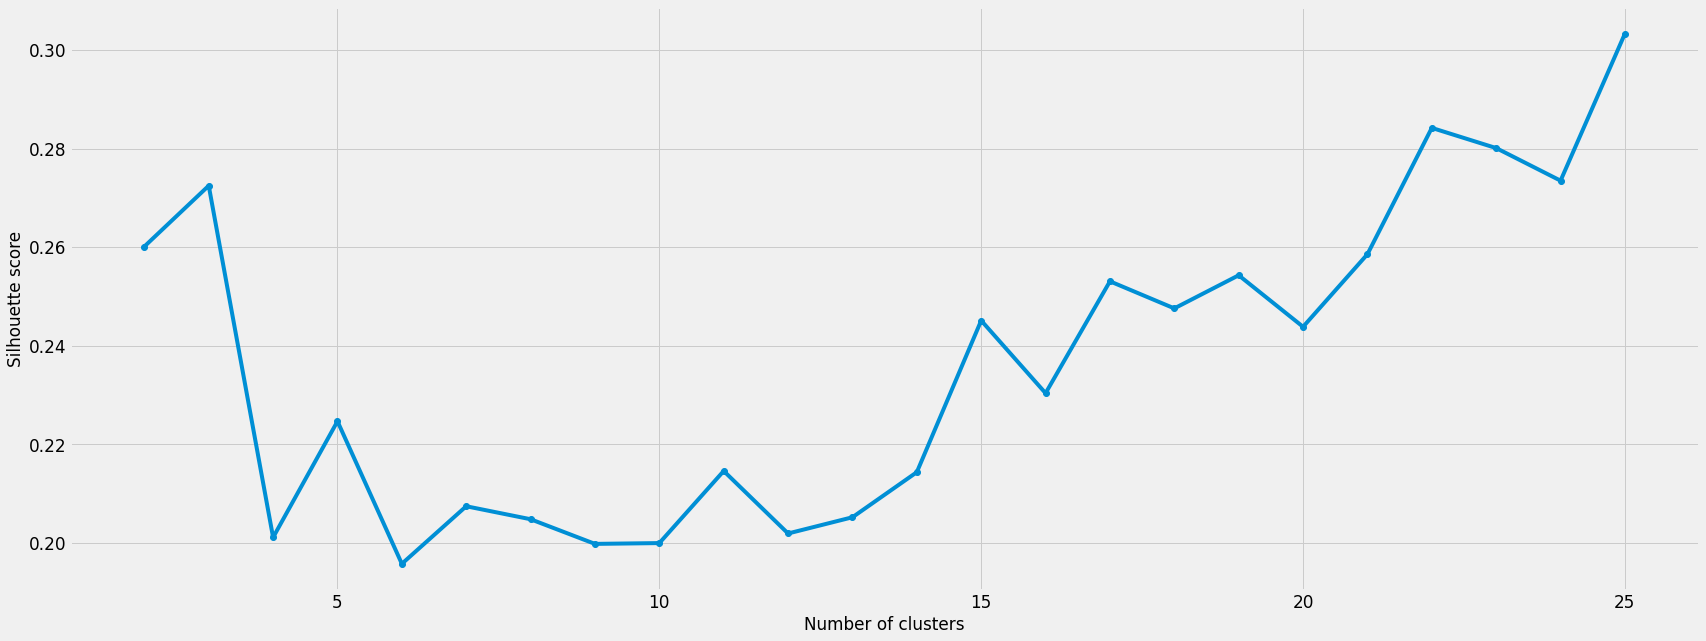

In [631]:
fm_nobo = fm_full.drop(['# of Runs','Boxoffice_Total','OW to YT','clusters'],axis=1)
plot_elbow_sil(fm_nobo,26)

In [632]:
#No BO Clustering

nobo_cluster = KMeans(n_clusters=25, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = nobo_cluster.fit_predict(fm_nobo)
fm_nobo['clusters']=pred_y

cluster_test = fm_nobo['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

Film (Distributor)
GOING IN STYLE (2017)                  0
LIFE OF THE PARTY                      0
MOTHERLESS BROOKLYN                    1
DOCTOR SLEEP (2019)                    1
KING ARTHUR: LEGEND OF THE SWORD       2
MEG, THE                               2
WONDER WOMAN                           2
GODZILLA: KING OF THE MONSTERS         2
CURSE OF LA LLORONA, THE               3
NUN, THE                               3
ANNABELLE: CREATION                    4
ANNABELLE COMES HOME                   4
SHAFT (2074539)                        4
KITCHEN, THE                           4
SMALLFOOT                              5
LEGO NINJAGO MOVIE, THE                5
FIST FIGHT                             6
GAME NIGHT                             6
IT (2017)                              7
STAR IS BORN, A (2024779)              7
JOKER                                  7
GOLDFINCH, THE                         7
EVERYTHING, EVERYTHING                 8
SUN IS ALSO A STAR, THE               

# NLP on Plot Overview

In [903]:
import string
import unicodedata

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser



def extract_bow_from_raw_text(text_as_string):
    """Extracts bag-of-words from a raw text string.

    Parameters
    ----------
    text (str): a text document given as a string

    Returns
    -------
    list : the list of the tokens extracted and filtered from the text
    """
    if (text_as_string == None):
        return []

    if (len(text_as_string) < 1):
        return []

    nfkd_form = unicodedata.normalize('NFKD', text_as_string)
    text_input = str(nfkd_form.encode('ASCII', 'ignore'))

    sent_tokens = sent_tokenize(text_input)

    tokens = list(map(word_tokenize, sent_tokens))

    sent_tags = list(map(pos_tag, tokens))

    grammar = r"""
        SENT: {<(J|N).*>}                # chunk sequences of proper nouns
    """

    cp = RegexpParser(grammar)
    ret_tokens = list()
    lemmatizer = WordNetLemmatizer()
    #stemmer_snowball = SnowballStemmer('english')

    for sent in sent_tags:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'SENT':
                t_tokenlist = [tpos[0].lower() for tpos in subtree.leaves()]
                t_tokens_lemma = list(map(lemmatizer.lemmatize, t_tokenlist))
               # t_tokens_stemsnowball = list(map(stemmer_snowball.stem, t_tokenlist))
                
                ret_tokens.extend(t_tokens_lemma)
                #ret_tokens.extend(t_tokens_stemsnowball)

    return(ret_tokens)
    

In [900]:
movie_text

0     The adventures of two California Highway Patro...
1     A cooler-than-ever Bruce Wayne must deal with ...
2     When one school teacher gets the other fired, ...
3     Julia moves in with her fiancé, David, but his...
4     Explore the mysterious and dangerous home of t...
                            ...                        
49    During the 1980s, a failed stand-up comedian i...
50    Still irrevocably scarred by the trauma he end...
51    New York City, 1957. Lionel Essrog, a private ...
52    Career con man Roy sets his sights on his late...
53    Richard Jewell thinks quick, works fast, and s...
Name: overview, Length: 54, dtype: object

In [901]:
docs = []
for desc in tqdm(movie_text):
    docs.append(desc)

In [904]:
# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row), docs))

In [905]:
# displaying bows
for i in range(len(docs)):
    print("\n--- Plot: {}".format(docs[i]))
    print("--- BoW: {}".format(bows[i]))


--- Plot: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- BoW: ["b'the", 'adventure', 'california', 'highway', 'patrol', 'motorcycle', 'officer', 'round', 'freeway', 'los', 'angeles']

--- Plot: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wishes to become his sidekick.
--- BoW: ['b', 'cooler-than-ever', 'bruce', 'wayne', 'usual', 'suspect', 'gotham', 'city', 'teenage', 'orphan', 'sidekick']

--- Plot: When one school teacher gets the other fired, he is challenged to an after-school fight.
--- BoW: ["b'when", 'school', 'other', 'after-school', 'fight']

--- Plot: Julia moves in with her fiancé, David, but his ex-wife and her own haunting past join forces to rock her quiet suburban existence.
--- BoW: ["b'julia", 'move', 'fiance', 'david', 'ex-wife', 'own', 'haunting', 'join', 'for

In [906]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), bows))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(bows[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- term_occ: {}".format(term_occ[i]))
    print("--- term_freq: {}".format(term_freq[i]))


--- review: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- bow: ["b'the", 'adventure', 'california', 'highway', 'patrol', 'motorcycle', 'officer', 'round', 'freeway', 'los', 'angeles']
--- term_occ: Counter({"b'the": 1, 'adventure': 1, 'california': 1, 'highway': 1, 'patrol': 1, 'motorcycle': 1, 'officer': 1, 'round': 1, 'freeway': 1, 'los': 1, 'angeles': 1})
--- term_freq: {"b'the": 0.09090909090909091, 'adventure': 0.09090909090909091, 'california': 0.09090909090909091, 'highway': 0.09090909090909091, 'patrol': 0.09090909090909091, 'motorcycle': 0.09090909090909091, 'officer': 0.09090909090909091, 'round': 0.09090909090909091, 'freeway': 0.09090909090909091, 'los': 0.09090909090909091, 'angeles': 0.09090909090909091}

--- review: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wis

In [907]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(docs)))
            for k, v in doc_occ.items()}

# displaying vocabulary
print("\n--- full vocabulary: {}".format(doc_occ))
print("\n--- doc freq: {}".format(doc_freq))


--- full vocabulary: Counter({'b': 24, 'life': 9, 'friend': 9, 'own': 8, 'world': 7, 'new': 7, 'everything': 6, 'year': 6, 'city': 5, 'force': 5, 'home': 5, 'boy': 5, 'team': 4, 'child': 4, 'first': 4, 'daughter': 4, 'monster': 4, 'young': 4, 'york': 4, 'family': 4, 'bruce': 3, 'other': 3, 'school': 3, "b'when": 3, 'island': 3, 'king': 3, 'father': 3, 'arthur': 3, 'way': 3, 'stone': 3, 'teenager': 3, 'man': 3, 'college': 3, 'dream': 3, 'night': 3, 'day': 3, 'series': 3, 'threat': 3, 'earth': 3, 'mother': 3, 'brother': 3, 'agent': 3, 'member': 3, 'people': 3, 'head': 3, 'game': 3, 'best': 3, 'living': 3, 'crime': 3, "b'the": 2, 'officer': 2, 'gotham': 2, 'wayne': 2, 'sidekick': 2, 'suburban': 2, 'existence': 2, 'deep': 2, 'ape': 2, 'pal': 2, 'money': 2, 'true': 2, 'idea': 2, 'door': 2, 'human': 2, 'war': 2, 'evil': 2, 'help': 2, 'need': 2, 'major': 2, 'britain': 2, 'army': 2, 'several': 2, 'little': 2, 'doll': 2, 'death': 2, 'nun': 2, 'target': 2, 'club': 2, 'pennywise': 2, 'loser': 2,

In [908]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.04

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),sorted(vocabulary)))

-- vocabulary (len=49): ['agent', 'arthur', 'b', "b'when", 'best', 'boy', 'brother', 'bruce', 'child', 'city', 'college', 'crime', 'daughter', 'day', 'dream', 'earth', 'everything', 'family', 'father', 'first', 'force', 'friend', 'game', 'head', 'home', 'island', 'king', 'life', 'living', 'man', 'member', 'monster', 'mother', 'new', 'night', 'other', 'own', 'people', 'school', 'series', 'stone', 'team', 'teenager', 'threat', 'way', 'world', 'year', 'york', 'young']


In [909]:
import numpy as np

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(docs),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
'''for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))
         '''

'for i in range(len(docs)):\n    print("\n--- review: {}".format(docs[i]))\n    print("--- bow: {}".format(bows[i]))\n    print("--- tfidf vector: {}".format( vectors[i] ) )\n    print("--- tfidf sorted: {}".format( \n            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )\n         ))\n         '

In [910]:
mv_tfidf = pd.DataFrame(data=vectors,columns=sorted(vocabulary))
mv_tfidf = mv_tfidf.rename(columns={"b'in":'in',"b'the":'the',"b'when":'when'})
mv_tfidf.drop('b',axis=1,inplace=True)

mv_tfidf

,agent,arthur,when,best,boy,brother,bruce,child,city,college,crime,daughter,day,dream,earth,everything,family,father,first,force,friend,game,head,home,island,king,life,living,man,member,monster,mother,new,night,other,own,people,school,series,stone,team,teenager,threat,way,world,year,york,young
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.107150,0.267676,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.588888,0.588888,0.588888,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.170641,0.205675,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.24537,0.205675,0.222846,0.24537,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.149685,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.452991
50,0.045333,0.000000,0.000000,0.000000,0.000000,0.078757,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.102852,0.0,0.113248,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.097296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133707,0.147222,0.147222,0.0,0.000000
52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.184027,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


# Sklearn TFIDF

In [ ]:
corpus = [row for row in docs]
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(stop_words='english')

document_tf_matrix = tf.fit_transform(corpus).todense()

sorted(tf.vocabulary_);
document_tf_matrix;

from math import log

def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
sorted(tf.vocabulary_);
idf(document_tf_matrix);

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
document_tfidf_matrix = tfidf.fit_transform(corpus)
#print(tfidf.vocabulary_)
print(document_tfidf_matrix.todense())

# PCA

In [911]:
from sklearn.decomposition import PCA
mv_tfidf_std = (mv_tfidf-np.mean(mv_tfidf))/np.std(mv_tfidf)
n_components = 2
mv_tfidf_pca = PCA(n_components=n_components).fit_transform(mv_tfidf_std.values)
#mv_tf_pca = movies_tfidf_std.values @ pca.components_.T
mv_tfidf_pca

array([[-0.19418133,  0.32122907],
       [ 1.3159093 , -0.57266467],
       [-2.57729619,  8.83623117],
       [ 0.65378972,  0.37632787],
       [-4.81941168, -1.47237308],
       [-0.19418133,  0.32122907],
       [-1.95841595, -4.77096261],
       [ 3.79660886, -1.0553411 ],
       [-1.05381451,  1.00530354],
       [-0.55525334,  1.56622374],
       [-0.26679103,  0.33940497],
       [-0.82225494, -0.37441203],
       [ 0.89923633, -0.19373608],
       [-0.69937511,  1.08511364],
       [-0.11668894, -0.11655454],
       [-0.06984002, -1.37090271],
       [ 0.16871082,  0.36291218],
       [-1.18110432, -3.55866908],
       [-3.9277382 , -3.63008155],
       [-1.21755014, -0.59546292],
       [-0.82173109,  1.4794813 ],
       [-0.72715777,  0.65735146],
       [-3.85760253, -0.62389309],
       [-0.45043626,  0.56265111],
       [-0.82473743, -0.05354648],
       [-1.19217009,  2.19036835],
       [-0.99703683,  0.63817988],
       [ 1.16747837, -0.06853049],
       [ 0.8570761 ,

Text(0, 0.5, 'Second Principal Component')

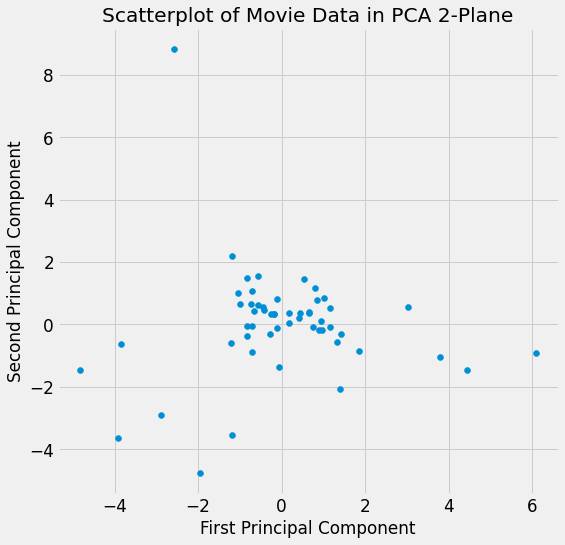

In [912]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(mv_tfidf_pca[:, 0], mv_tfidf_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

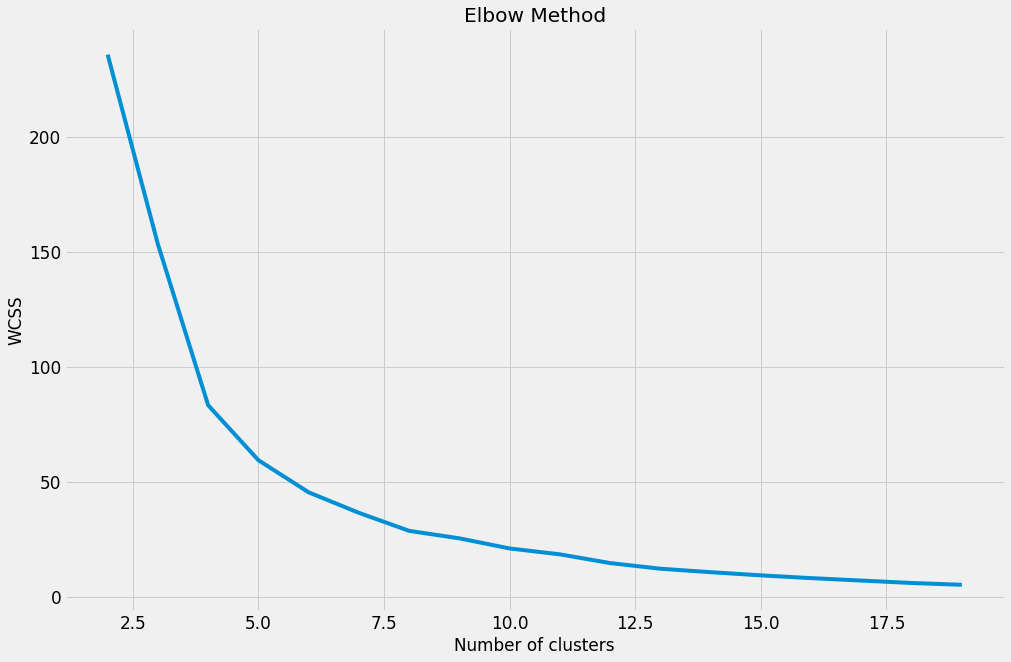

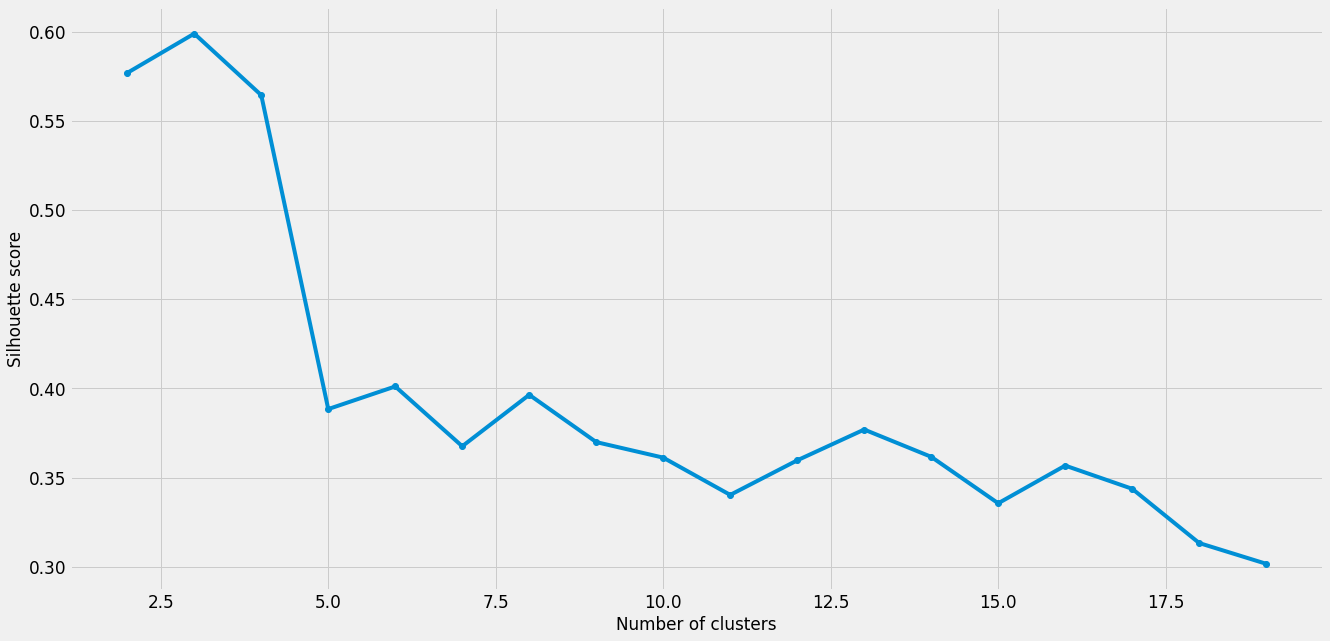

In [913]:
plot_elbow_sil(mv_tfidf_pca,20)

In [723]:
with pd.option_context("display.max_rows", 1000):
    display(genre_df['TITLE'])

0                                                 Chips
1                           Lego Batman Movie - 3D/IMAX
2                                            Fist Fight
3                                         Unforgettable
4                          Kong: Skull Island - 3D/IMAX
5                                        Going In Style
6                 King Arthur: Legend Of The Sword - 3D
7                                Everything, Everything
8                                Wonder Woman - 3D/IMAX
9                                            House, The
10                                       Dunkirk - IMAX
11                                  Annabelle: Creation
12                                              It (NL)
13                   Lego Ninjago Movie, The (Ani) - 3D
14                  Blade Runner 2049 - Alcon - 3D/IMAX
15                                   Geostorm - 3D/IMAX
16                                         Paddington 2
17                             Justice League - 

In [915]:
#Movie Clustering + Genre DF for title
pca_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = pca_cluster.fit_predict(mv_tfidf_pca)

mv_pca = pd.DataFrame(mv_tfidf_pca, columns = ('PCA1','PCA2'))
mv_pca = mv_pca.join(genre_df[['TITLE','title']],how='left')
mv_pca['Film (Distributor)'] = mv_pca['title'] 
mv_pca.set_index('Film (Distributor)',inplace=True)
mv_pca['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca['clusters']

with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

Film (Distributor)
CHIPS (2017)                           0
ANNABELLE COMES HOME                   0
SHAFT (2074539)                        0
POKEMON DETECTIVE PIKACHU              0
GOOD LIAR, THE                         0
READY PLAYER ONE                       0
GAME NIGHT                             0
LEGO NINJAGO MOVIE, THE                0
DUNKIRK (2017)                         0
TAG (2018)                             0
WONDER WOMAN                           0
GOING IN STYLE (2017)                  0
JUSTICE LEAGUE (2017)                  1
KING ARTHUR: LEGEND OF THE SWORD       1
FIST FIGHT                             2
LEGO MOVIE 2, THE: THE SECOND PART     3
GOLDFINCH, THE                         3
LEGO BATMAN MOVIE, THE                 3
DOCTOR SLEEP (2019)                    3
KONG: SKULL ISLAND                     4
TOMB RAIDER                            4
BLADE RUNNER 2049                      5
GODZILLA: KING OF THE MONSTERS         5
RAMPAGE (2018)                        

In [850]:
# Text PCA + No Boxoffice Dataframe 
mv_pca_full = mv_pca.join(fm_nobo,how='left',lsuffix="_x",rsuffix="_y")
mv_pca_full.drop(['title','TITLE','clusters_x','clusters_y'],axis=1,inplace=True)

#scale = StandardScaler()
#runtime = mv_pca_full['ow_by_runtime']
#transform = scale.fit_transform(runtime.values.reshape(-1,1))
#mv_pca_full['ow_by_runtime']= transform

mv_pca_full

,PCA1,PCA2,budget,runtime,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter,Rating_PG13,Rating_R
Film (Distributor),,,,,,,,,,,,,,,,,,,,
CHIPS (2017),-0.128675,0.287367,-0.712037,-0.768135,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
"LEGO BATMAN MOVIE, THE",-0.931267,-1.729536,0.189007,-0.563804,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
FIST FIGHT,-1.694572,9.678281,-0.761185,-1.227881,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
UNFORGETTABLE,-0.489758,0.098712,-0.925012,-0.768135,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
KONG: SKULL ISLAND,4.881373,2.349721,1.909183,0.151357,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JOKER,-1.057428,-1.406313,-0.220559,0.355688,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
DOCTOR SLEEP (2019),-0.518571,-0.085728,-0.384385,1.888175,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
MOTHERLESS BROOKLYN,-2.071742,-0.270274,-0.695655,1.530595,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(mv_pca_full)

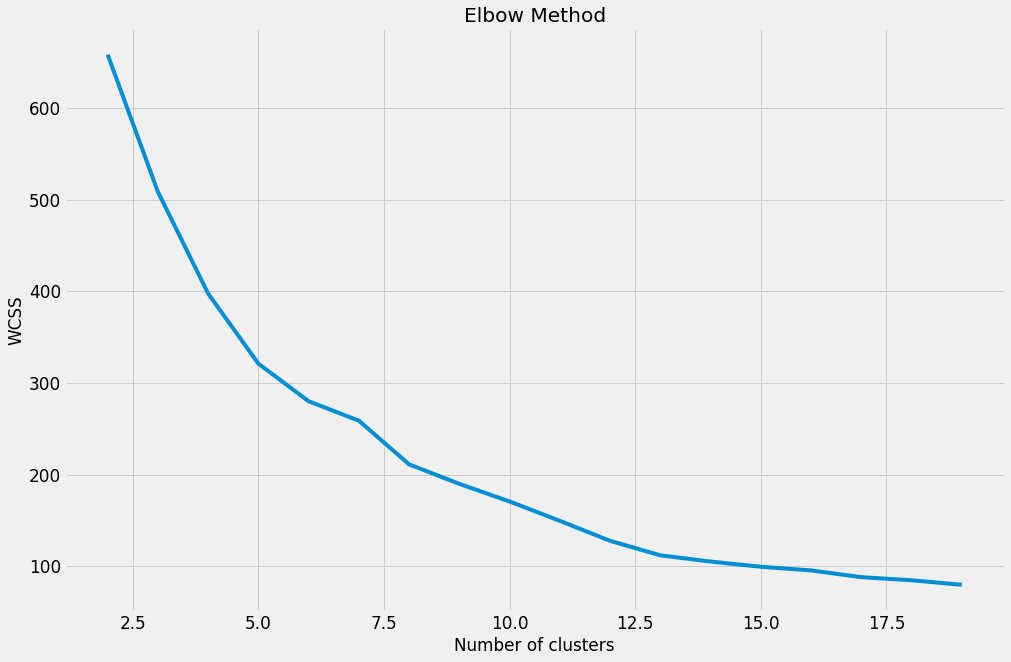

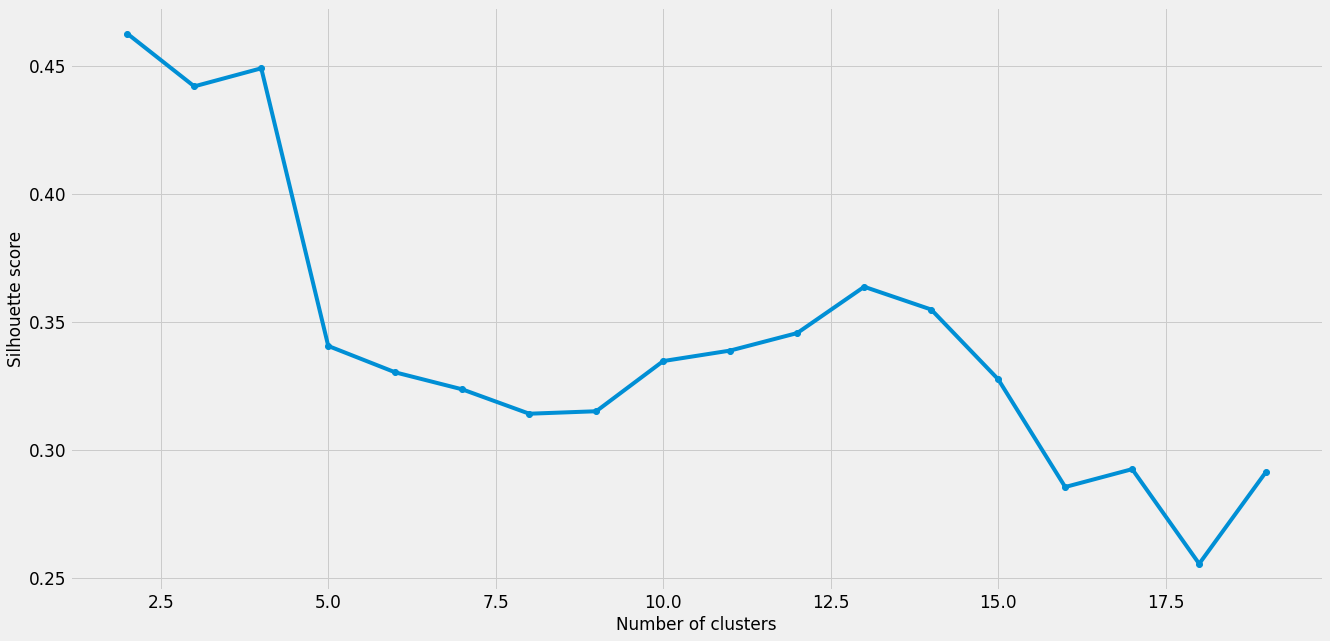

In [916]:
plot_elbow_sil(mv_pca_full,20)

In [917]:
#Movie Clustering
tfidf_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = tfidf_cluster.fit_predict(mv_pca_full)
mv_pca_full['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

Film (Distributor)
TAG (2018)                             0
KITCHEN, THE                           0
ANNABELLE COMES HOME                   0
SHAFT (2074539)                        0
GOOD LIAR, THE                         0
ANNABELLE: CREATION                    0
SMALLFOOT                              1
NUN, THE                               1
TEEN TITANS GO! TO THE MOVIES          1
GAME NIGHT                             1
PADDINGTON 2                           1
CHIPS (2017)                           1
GOING IN STYLE (2017)                  1
UNFORGETTABLE                          1
AQUAMAN (2018)                         2
WONDER WOMAN                           2
FATHER FIGURES                         2
KING ARTHUR: LEGEND OF THE SWORD       2
DUNKIRK (2017)                         3
RAMPAGE (2018)                         3
READY PLAYER ONE                       3
GODZILLA: KING OF THE MONSTERS         3
SHAZAM! (2019)                         3
GEOSTORM                              

In [918]:
fm_full_clusters = fm_full.reset_index()[['Film (Distributor)','clusters']]

In [919]:
iter5_1hot = iter5[['Film (Distributor)','over_index','Media_Formats_3D','Media_Formats_IMAX','Media_Formats_PLF','Division_EASTERN','Division_SOUTHERN','Division_WESTERN']]

In [920]:
iter5_full = iter5_1hot.merge(fm_full_clusters, how='left',on='Film (Distributor)')
iter5_full.drop('Film (Distributor)',axis=1,inplace=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


LR: Recall Score - 0.5574
DT: Recall Score - 0.6411
RF: Recall Score - 0.6412
GB: Recall Score - 0.6403


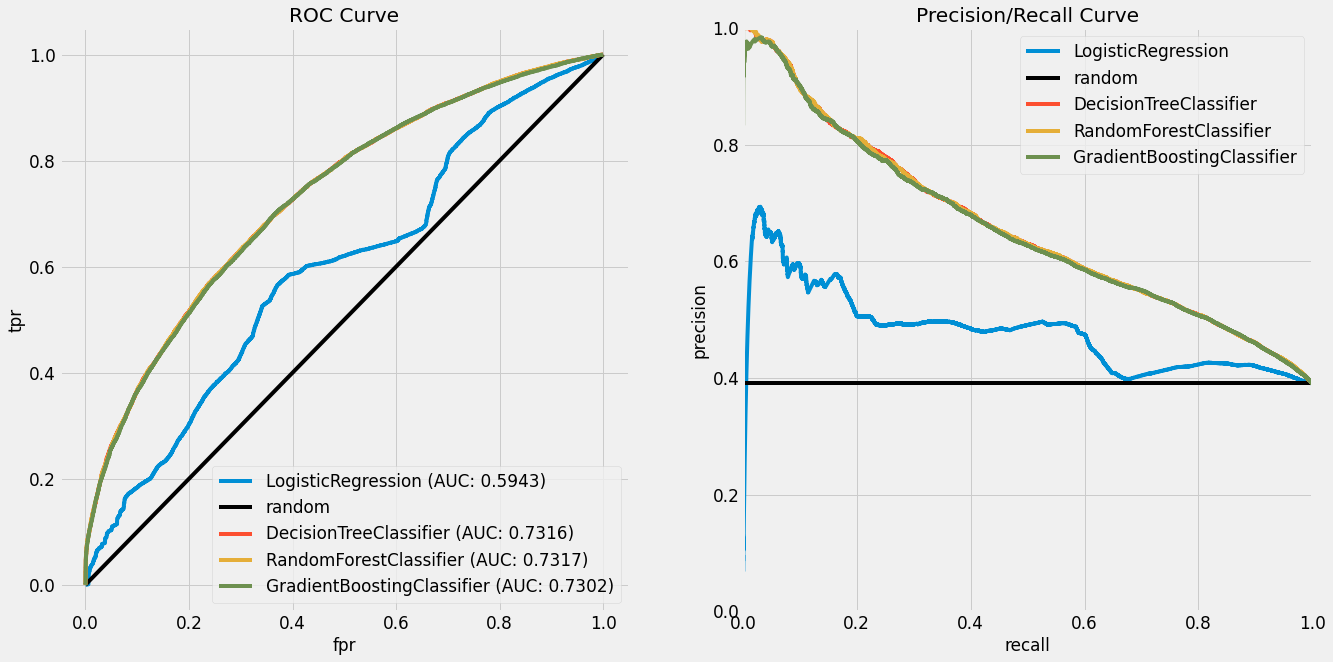

In [921]:
y = iter5_full['over_index']
X = iter5_full.drop('over_index',axis=1)
plot_models(X,y)